In [53]:
pip install obspy


#**WAVEFORM RENDAH**

DATA JEPANG

In [54]:
import os
import numpy as np
import matplotlib.pyplot as plt
from obspy import read, UTCDateTime
from scipy.signal import welch

def basic_stats(tr):
    data = tr.data.astype(float)
    return {
        "npts": tr.stats.npts,
        "fs": tr.stats.sampling_rate, #sampling rate
        "duration_s": tr.stats.npts / tr.stats.sampling_rate, #menunjukkan durasi
        "min": np.min(data), #nilai min amplitudo
        "max": np.max(data), #nilai max amplitudo
        "mean": np.mean(data),
        "std": np.std(data), #men
    }

def is_clipped(tr, threshold_ratio=0.99):
    d = tr.data.astype(float)
    absmax = np.max(np.abs(d))
    n_close = np.sum(np.isclose(np.abs(d), absmax, atol=1e-8) | (np.abs(d) > absmax * threshold_ratio))
    frac = n_close / len(d)
    return frac > 0.001, frac

def estimate_snr(tr, pre_pick_sec=10.0, event_sec=20.0):
    n = tr.stats.npts
    fs = tr.stats.sampling_rate
    if n < int(fs*(pre_pick_sec+event_sec+1)):
        mid = n//2
        noise = tr.data[:mid]
        signal = tr.data[mid:]
    else:
        noise = tr.data[:int(fs*pre_pick_sec)]
        signal = tr.data[int(fs*pre_pick_sec):int(fs*(pre_pick_sec+event_sec))]
    noise_rms = np.sqrt(np.mean(noise**2)) + 1e-12
    signal_rms = np.sqrt(np.mean(signal**2)) + 1e-12
    return 20*np.log10(signal_rms / noise_rms)

def plot_spectrum(tr, ax=None):
    f, Pxx = welch(tr.data, fs=tr.stats.sampling_rate, nperseg=2048)
    if ax is None:
        plt.semilogy(f, Pxx)
        plt.xlabel("Hz"); plt.ylabel("PSD")
    else:
        ax.semilogy(f, Pxx)
        ax.set_xlabel("Hz"); ax.set_ylabel("PSD")

sac_files = [
    "/content/II.ERM.00.BH1.M.2025.342.141431.SAC",
    "/content/II.ERM.00.BH2.M.2025.342.141431.SAC",
    "/content/II.ERM.00.BHZ.M.2025.342.141431.SAC",
    "/content/II.ERM.10.BH1.M.2025.342.141431.SAC",
    "/content/II.ERM.10.BH2.M.2025.342.141431.SAC",
    "/content/II.ERM.10.BHZ.M.2025.342.141431.SAC"
]

results = []
for fpath in sac_files:
    if not os.path.exists(fpath):
        print("File not found:", fpath)
        continue
    st = read(fpath)
    tr = st[0]
    stats = basic_stats(tr)
    clipped, frac_clipped = is_clipped(tr)
    snr_db = estimate_snr(tr)
    results.append({
        "file": fpath,
        "channel": tr.stats.channel,
        "location": tr.stats.location,
        **stats,
        "clipped": clipped,
        "frac_clipped": frac_clipped,
        "snr_db": snr_db
    })


Kode program ini digunakan untuk membaca dan mengevaluasi kualitas data seismik gempa bumi dalam format SAC. Program diawali dengan mengimpor library yang diperlukan untuk pengolahan numerik, visualisasi, dan pembacaan data seismik. Fungsi basic_stats digunakan untuk menghitung statistik dasar sinyal seperti jumlah data, sampling rate, durasi, nilai minimum, maksimum, rata-rata, dan standar deviasi amplitudo. Fungsi is_clipped bertujuan mendeteksi apakah sinyal mengalami clipping, yaitu kondisi saat amplitudo mendekati batas maksimum perekaman yang dapat merusak kualitas data. Selanjutnya, fungsi estimate_snr menghitung nilai Signal-to-Noise Ratio (SNR) dengan membandingkan energi sinyal gempa terhadap noise, sehingga kualitas sinyal dapat dinilai secara kuantitatif. Fungsi plot_spectrum digunakan untuk menganalisis spektrum frekuensi sinyal menggunakan metode Welch (PSD). Program kemudian membaca beberapa file SAC dari berbagai kanal dan lokasi, menghitung seluruh parameter kualitas sinyal tersebut, dan menyimpan hasilnya ke dalam variabel results untuk digunakan pada analisis lanjutan dan perbandingan antar kanal maupun lokasi.

                                           file location channel    fs  \
0  /content/II.ERM.00.BH1.M.2025.342.141431.SAC       00     BH1  20.0   
1  /content/II.ERM.00.BH2.M.2025.342.141431.SAC       00     BH2  20.0   
2  /content/II.ERM.00.BHZ.M.2025.342.141431.SAC       00     BHZ  20.0   
3  /content/II.ERM.10.BH1.M.2025.342.141431.SAC       10     BH1  40.0   
4  /content/II.ERM.10.BH2.M.2025.342.141431.SAC       10     BH2  40.0   
5  /content/II.ERM.10.BHZ.M.2025.342.141431.SAC       10     BHZ  40.0   

   duration_s         min         max           std  clipped  frac_clipped  \
0       660.0 -37738952.0  37170516.0  6.668663e+06    False      0.000152   
1       660.0 -39033084.0  37094896.0  7.310152e+06    False      0.000227   
2       660.0 -39645248.0  36985188.0  6.589631e+06    False      0.000076   
3       660.0 -40689084.0  40066276.0  4.319285e+06    False      0.000152   
4       660.0 -40467976.0  40238732.0  6.175871e+06    False      0.000644   
5       660.0

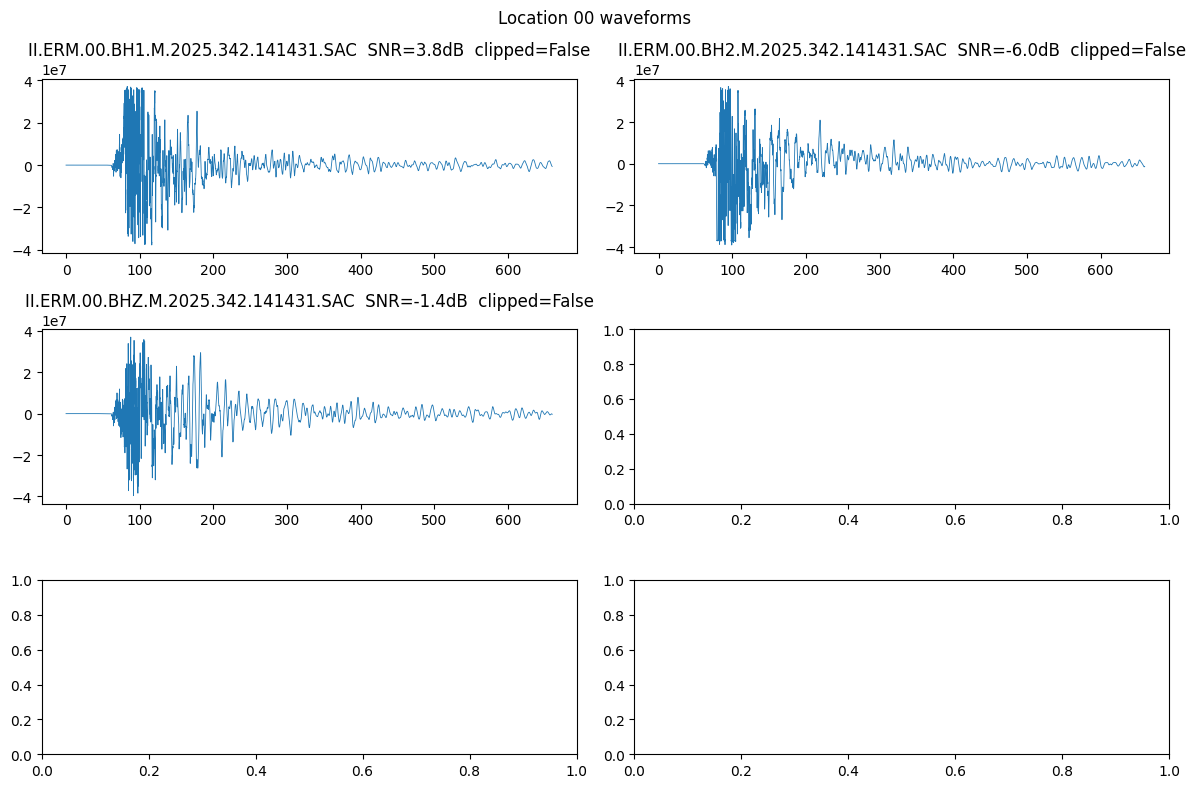

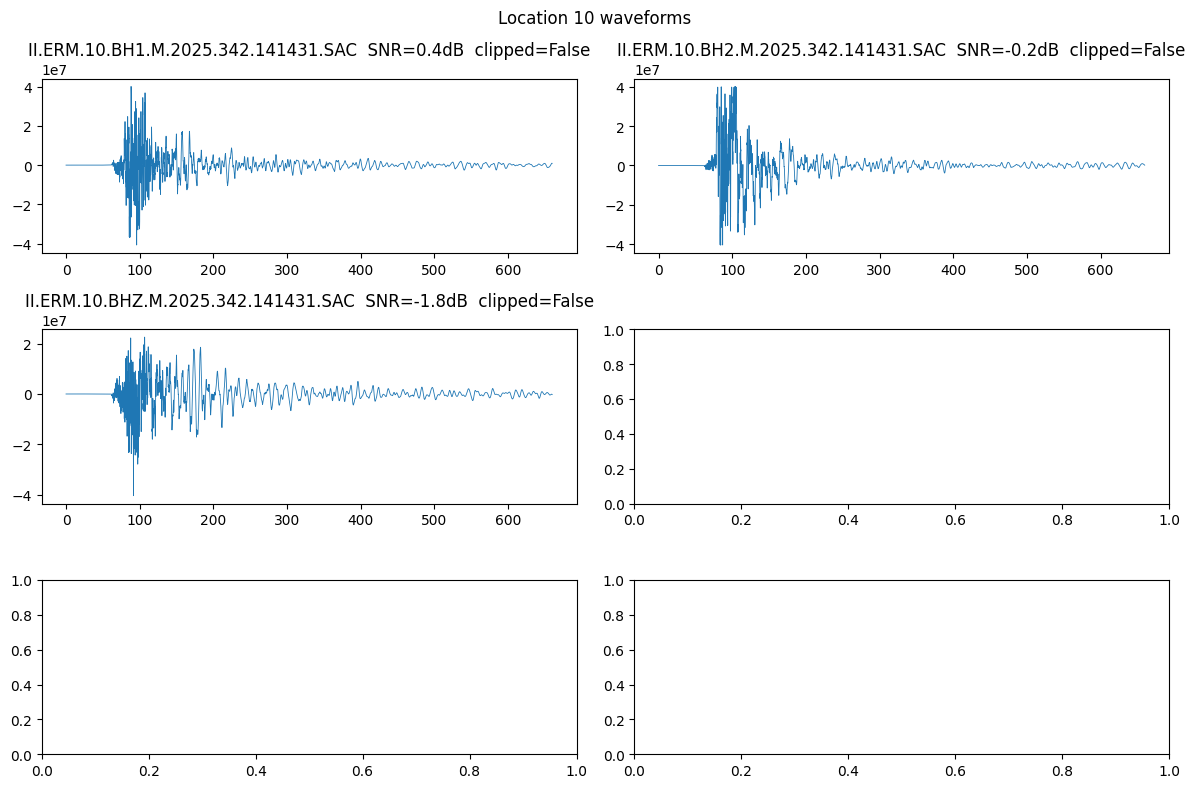

In [55]:
import pandas as pd
df = pd.DataFrame(results)
print(df[["file","location","channel","fs","duration_s","min","max","std","clipped","frac_clipped","snr_db"]])

locations = sorted(df['location'].unique())
for loc in locations:
    sel = df[df['location']==loc]
    if sel.empty: continue
    fig, axes = plt.subplots(3,2, figsize=(12,8))
    axes = axes.flatten()
    for idx, (i, row) in enumerate(sel.iterrows()):
        tr = read(row['file'])[0]
        ax = axes[idx]
        t = np.arange(tr.stats.npts)/tr.stats.sampling_rate
        ax.plot(t, tr.data, linewidth=0.6)
        ax.set_title(f"{os.path.basename(row['file'])}  SNR={row['snr_db']:.1f}dB  clipped={row['clipped']}")
    plt.suptitle(f"Location {loc} waveforms")
    plt.tight_layout()
    plt.show()

Kode ini digunakan untuk menyusun hasil analisis data seismik ke dalam bentuk tabel dan menampilkan visualisasi sinyal gempa berdasarkan lokasi perekaman. Data hasil perhitungan sebelumnya disimpan ke dalam DataFrame Pandas agar mudah dibaca dan dibandingkan, termasuk informasi file, kanal, lokasi, durasi, statistik amplitudo, status clipping, dan nilai SNR. Selanjutnya, kode mengelompokkan data berdasarkan lokasi sensor dan menampilkan waveform sinyal untuk setiap kanal dalam satu lokasi menggunakan grafik domain waktu. Pada setiap grafik ditambahkan informasi nama file, nilai SNR, dan status clipping untuk memudahkan evaluasi kualitas sinyal. Visualisasi ini membantu membandingkan karakteristik dan kualitas sinyal gempa antar kanal dan lokasi secara langsung.

                                           file location channel    fs  \
0  /content/II.ERM.00.BH1.M.2025.342.141431.SAC       00     BH1  20.0   
1  /content/II.ERM.00.BH2.M.2025.342.141431.SAC       00     BH2  20.0   
2  /content/II.ERM.00.BHZ.M.2025.342.141431.SAC       00     BHZ  20.0   
3  /content/II.ERM.10.BH1.M.2025.342.141431.SAC       10     BH1  40.0   
4  /content/II.ERM.10.BH2.M.2025.342.141431.SAC       10     BH2  40.0   
5  /content/II.ERM.10.BHZ.M.2025.342.141431.SAC       10     BHZ  40.0   

   duration_s         min         max           std  clipped  frac_clipped  \
0       660.0 -37738952.0  37170516.0  6.668663e+06    False      0.000152   
1       660.0 -39033084.0  37094896.0  7.310152e+06    False      0.000227   
2       660.0 -39645248.0  36985188.0  6.589631e+06    False      0.000076   
3       660.0 -40689084.0  40066276.0  4.319285e+06    False      0.000152   
4       660.0 -40467976.0  40238732.0  6.175871e+06    False      0.000644   
5       660.0

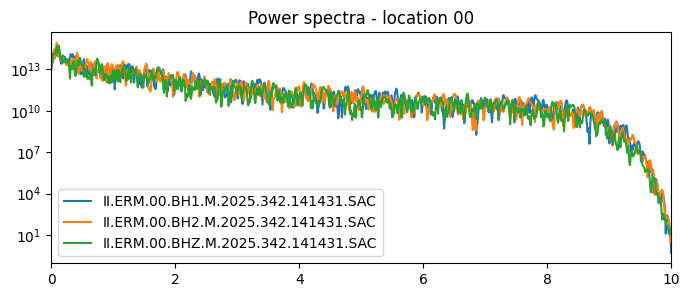

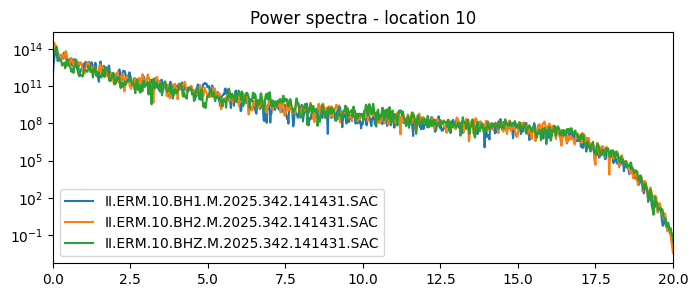

In [56]:
import pandas as pd
df = pd.DataFrame(results)
print(df[["file","location","channel","fs","duration_s","min","max","std","clipped","frac_clipped","snr_db"]])

locations = sorted(df['location'].unique())
for loc in locations:
    sel = df[df['location']==loc]
    if sel.empty: continue
    fig, ax = plt.subplots(1,1, figsize=(8,3))
    for i, row in sel.iterrows():
        tr = read(row['file'])[0]
        f, Pxx = welch(tr.data, fs=tr.stats.sampling_rate, nperseg=2048)
        ax.semilogy(f, Pxx, label=os.path.basename(row['file']))
    ax.set_xlim(0, tr.stats.sampling_rate/2)
    ax.legend()
    ax.set_title(f"Power spectra - location {loc}")
    plt.show()

Kode ini digunakan untuk menyajikan dan membandingkan spektrum daya (Power Spectral Density/PSD) sinyal gempa pada setiap lokasi perekaman. Hasil analisis sebelumnya disusun ke dalam DataFrame agar informasi kualitas sinyal seperti SNR, durasi, dan statistik amplitudo dapat ditampilkan secara terstruktur. Selanjutnya, data dikelompokkan berdasarkan lokasi sensor, lalu untuk setiap lokasi dibuat satu grafik PSD yang menampilkan seluruh kanal (BH1, BH2, dan BHZ) secara bersamaan. Perhitungan PSD dilakukan menggunakan metode Welch untuk menunjukkan distribusi energi sinyal pada berbagai frekuensi. Grafik ini membantu mengidentifikasi frekuensi dominan dan membandingkan karakteristik energi sinyal antar kanal dalam satu lokasi, sehingga memudahkan evaluasi kualitas dan konsistensi data seismik.

In [57]:
loc_scores = {}
for loc in locations:
    sel = df[df['location']==loc]
    if sel.empty: continue
    score = sel['snr_db'].median() - (sel['frac_clipped'].median()*1000)
    loc_scores[loc] = score
print("Location scores:", loc_scores)
best_loc = max(loc_scores, key=loc_scores.get)
print("Recommended location:", best_loc)
print("Recommended files (3-component):")
print(df[df['location']==best_loc]['file'].tolist())

Location scores: {'00': -1.5860858216430203, '10': -0.33043063725485944}
Recommended location: 10
Recommended files (3-component):
['/content/II.ERM.10.BH1.M.2025.342.141431.SAC', '/content/II.ERM.10.BH2.M.2025.342.141431.SAC', '/content/II.ERM.10.BHZ.M.2025.342.141431.SAC']


Kode ini menampilkan daftar file SAC dari lokasi terbaik, biasanya terdiri dari tiga komponen (BH1, BH2, dan BHZ).
File inilah yang direkomendasikan untuk analisis lanjutan karena memiliki kualitas sinyal paling baik.

/usr/local/lib/python3.12/dist-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (20) of bandpass is at or above Nyquist (10.0). Applying a high-pass instead.
  warnings.warn(msg)


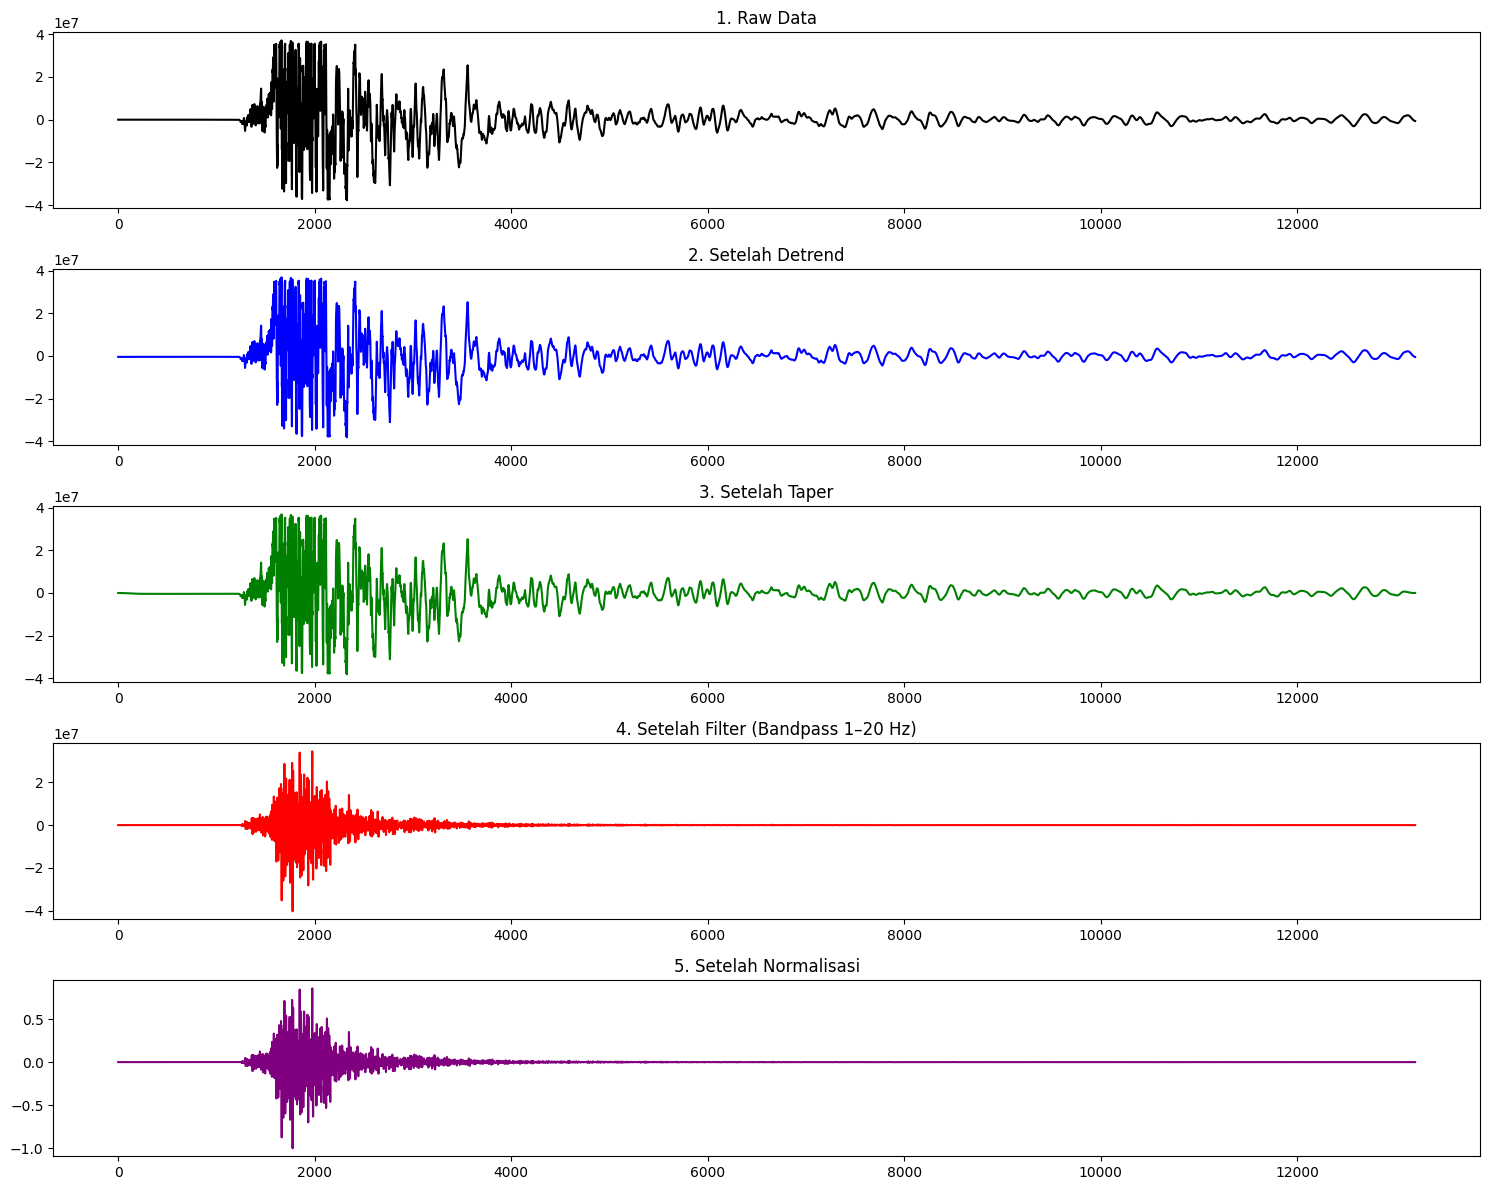

In [58]:
import matplotlib.pyplot as plt
from obspy import read
import numpy as np

# --- 1. Load data ---
tr_raw = read("/content/II.ERM.00.BH1.M.2025.342.141431.SAC")[0]

# Copy agar tidak overwrite
tr_detrend = tr_raw.copy()
tr_taper   = tr_raw.copy()
tr_filter  = tr_raw.copy()
tr_norm    = tr_raw.copy()

# --- 2. Apply processing step by step ---
tr_detrend.detrend("linear")
tr_taper.detrend("linear")
tr_taper.taper(max_percentage=0.02, type="cosine")

tr_filter.detrend("linear")
tr_filter.taper(max_percentage=0.02, type="cosine")
tr_filter.filter("bandpass", freqmin=1, freqmax=20)

tr_norm.detrend("linear")
tr_norm.taper(max_percentage=0.02, type="cosine")
tr_norm.filter("bandpass", freqmin=1, freqmax=20)
data_norm = tr_norm.data / np.max(np.abs(tr_norm.data))


# --- 3. Plot all steps ---
plt.figure(figsize=(15, 12))

# Raw
plt.subplot(5,1,1)
plt.plot(tr_raw.data, color="black")
plt.title("1. Raw Data")

# Detrend : digunakan untuk menghilangkan tren linier atau offset pada sinyal.
plt.subplot(5,1,2)
plt.plot(tr_detrend.data, color="blue")
plt.title("2. Setelah Detrend")

# Taper : untuk menghaluskan bagian awal dan akhir sinyal.
plt.subplot(5,1,3)
plt.plot(tr_taper.data, color="green")
plt.title("3. Setelah Taper")

# Filter : untuk menyaring frekuensi yang relevan dengan gempa.
plt.subplot(5,1,4)
plt.plot(tr_filter.data, color="red")
plt.title("4. Setelah Filter (Bandpass 1–20 Hz)")

# Normalisasi: dilakukan dengan membagi sinyal terhadap amplitudo maksimum.
plt.subplot(5,1,5)
plt.plot(data_norm, color="purple")
plt.title("5. Setelah Normalisasi")
plt.tight_layout()
plt.show()


ode ini menunjukkan tahapan preprocessing sinyal gempa mulai dari data mentah hingga sinyal yang telah dinormalisasi. Setiap tahap bertujuan untuk membersihkan sinyal sehingga hasil analisis frekuensi dan energi menjadi lebih akurat.

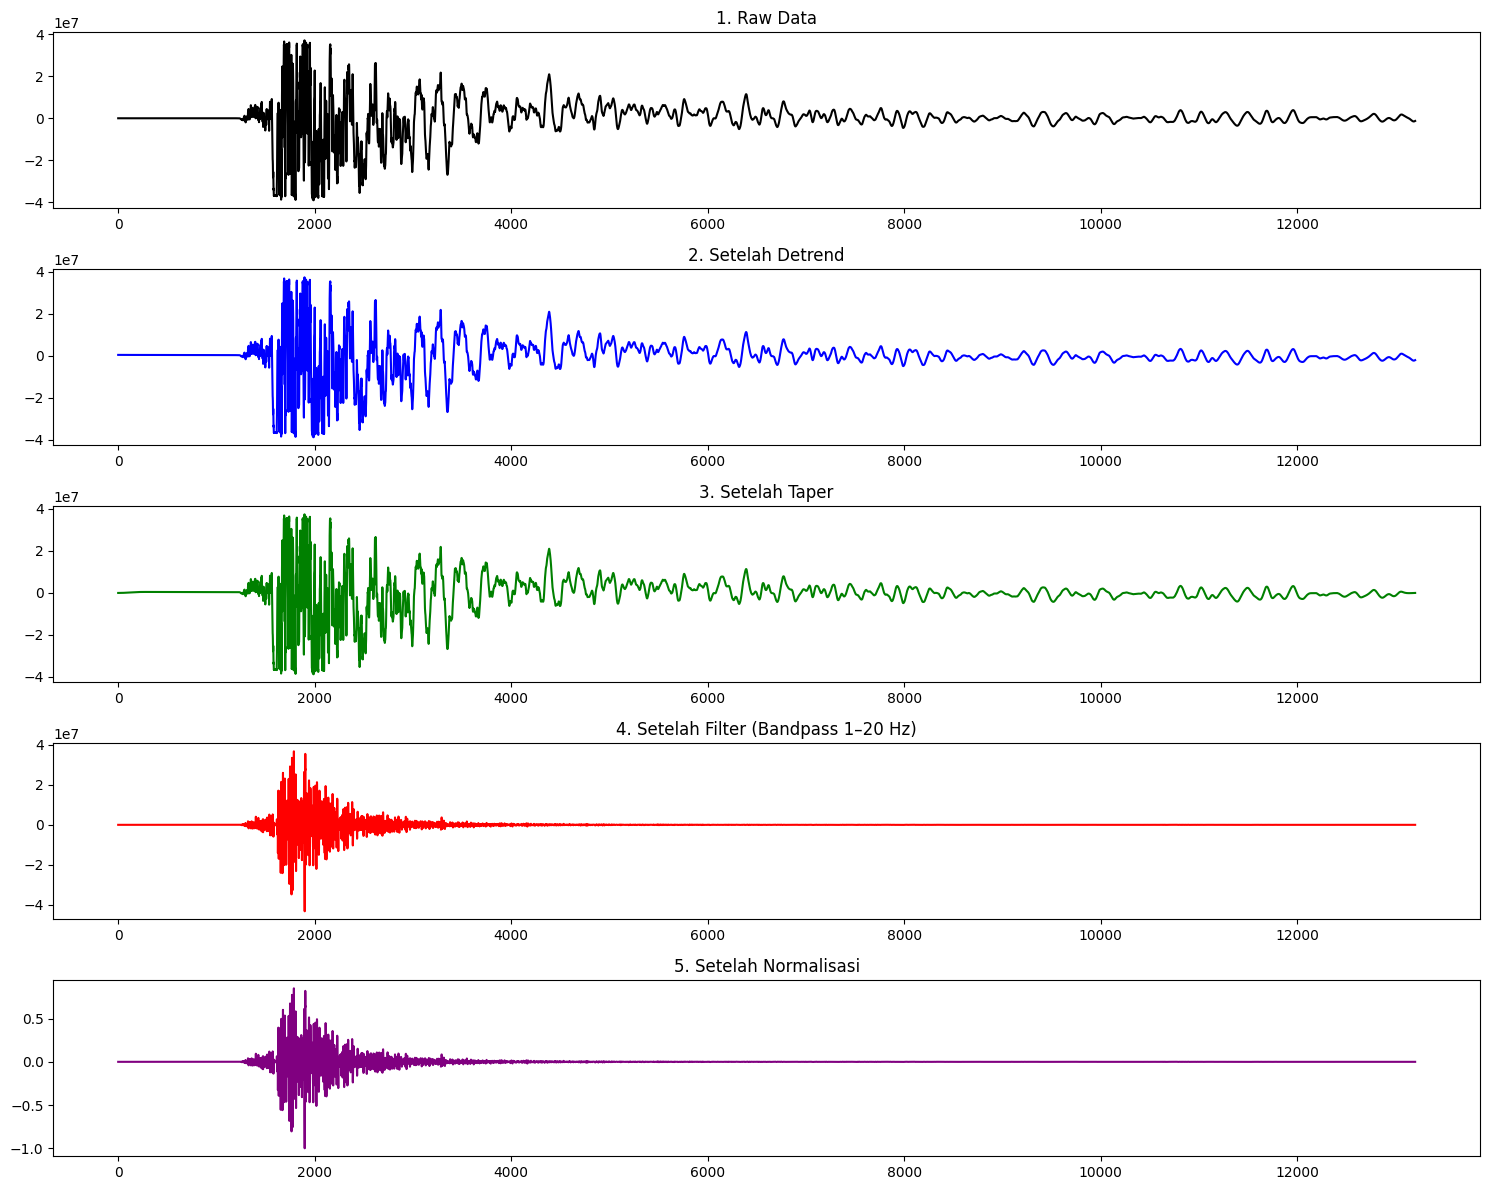

In [59]:
import matplotlib.pyplot as plt
from obspy import read
import numpy as np

# --- 1. Load data ---
tr_raw = read("/content/II.ERM.00.BH2.M.2025.342.141431.SAC")[0]

# Copy agar tidak overwrite
tr_detrend = tr_raw.copy()
tr_taper   = tr_raw.copy()
tr_filter  = tr_raw.copy()
tr_norm    = tr_raw.copy()

# --- 2. Apply processing step by step ---
tr_detrend.detrend("linear")
tr_taper.detrend("linear")
tr_taper.taper(max_percentage=0.02, type="cosine")

tr_filter.detrend("linear")
tr_filter.taper(max_percentage=0.02, type="cosine")
tr_filter.filter("bandpass", freqmin=1, freqmax=20)

tr_norm.detrend("linear")
tr_norm.taper(max_percentage=0.02, type="cosine")
tr_norm.filter("bandpass", freqmin=1, freqmax=20)
data_norm = tr_norm.data / np.max(np.abs(tr_norm.data))


# --- 3. Plot all steps ---
plt.figure(figsize=(15, 12))

# Raw
plt.subplot(5,1,1)
plt.plot(tr_raw.data, color="black")
plt.title("1. Raw Data")

# Detrend : digunakan untuk menghilangkan tren linier atau offset pada sinyal.
plt.subplot(5,1,2)
plt.plot(tr_detrend.data, color="blue")
plt.title("2. Setelah Detrend")

# Taper : untuk menghaluskan bagian awal dan akhir sinyal.
plt.subplot(5,1,3)
plt.plot(tr_taper.data, color="green")
plt.title("3. Setelah Taper")

# Filter : untuk menyaring frekuensi yang relevan dengan gempa.
plt.subplot(5,1,4)
plt.plot(tr_filter.data, color="red")
plt.title("4. Setelah Filter (Bandpass 1–20 Hz)")

# Normalisasi: dilakukan dengan membagi sinyal terhadap amplitudo maksimum.
plt.subplot(5,1,5)
plt.plot(data_norm, color="purple")
plt.title("5. Setelah Normalisasi")
plt.tight_layout()
plt.show()

ode ini menunjukkan tahapan preprocessing sinyal gempa mulai dari data mentah hingga sinyal yang telah dinormalisasi. Setiap tahap bertujuan untuk membersihkan sinyal sehingga hasil analisis frekuensi dan energi menjadi lebih akurat.

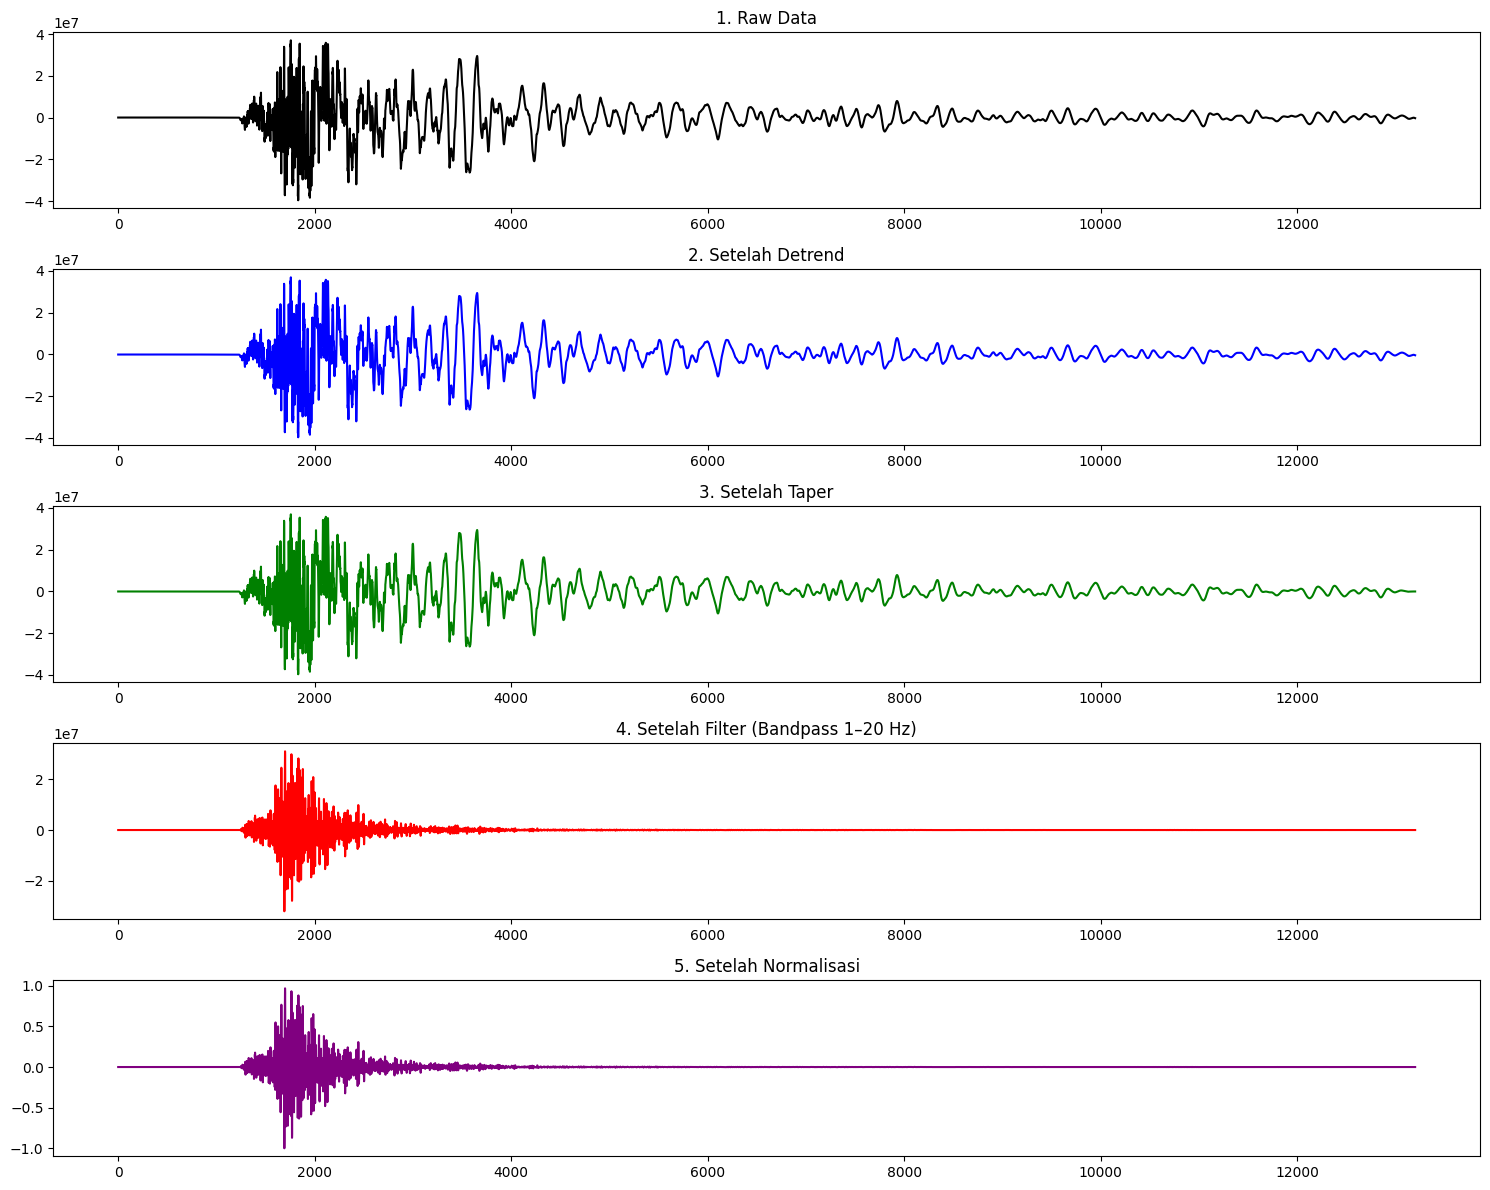

In [60]:
import matplotlib.pyplot as plt
from obspy import read
import numpy as np

# --- 1. Load data ---
tr_raw = read("/content/II.ERM.00.BHZ.M.2025.342.141431.SAC")[0]

# Copy agar tidak overwrite
tr_detrend = tr_raw.copy()
tr_taper   = tr_raw.copy()
tr_filter  = tr_raw.copy()
tr_norm    = tr_raw.copy()

# --- 2. Apply processing step by step ---
tr_detrend.detrend("linear")
tr_taper.detrend("linear")
tr_taper.taper(max_percentage=0.02, type="cosine")

tr_filter.detrend("linear")
tr_filter.taper(max_percentage=0.02, type="cosine")
tr_filter.filter("bandpass", freqmin=1, freqmax=20)

tr_norm.detrend("linear")
tr_norm.taper(max_percentage=0.02, type="cosine")
tr_norm.filter("bandpass", freqmin=1, freqmax=20)
data_norm = tr_norm.data / np.max(np.abs(tr_norm.data))


# --- 3. Plot all steps ---
plt.figure(figsize=(15, 12))

# Raw
plt.subplot(5,1,1)
plt.plot(tr_raw.data, color="black")
plt.title("1. Raw Data")

# Detrend : digunakan untuk menghilangkan tren linier atau offset pada sinyal.
plt.subplot(5,1,2)
plt.plot(tr_detrend.data, color="blue")
plt.title("2. Setelah Detrend")

# Taper : untuk menghaluskan bagian awal dan akhir sinyal.
plt.subplot(5,1,3)
plt.plot(tr_taper.data, color="green")
plt.title("3. Setelah Taper")

# Filter : untuk menyaring frekuensi yang relevan dengan gempa.
plt.subplot(5,1,4)
plt.plot(tr_filter.data, color="red")
plt.title("4. Setelah Filter (Bandpass 1–20 Hz)")

# Normalisasi: dilakukan dengan membagi sinyal terhadap amplitudo maksimum.
plt.subplot(5,1,5)
plt.plot(data_norm, color="purple")
plt.title("5. Setelah Normalisasi")
plt.tight_layout()
plt.show()

Kode ini menunjukkan tahapan preprocessing sinyal gempa mulai dari data mentah hingga sinyal yang telah dinormalisasi. Setiap tahap bertujuan untuk membersihkan sinyal sehingga hasil analisis frekuensi dan energi menjadi lebih akurat.

In [61]:
data = tr.data
data = data / max(abs(data))
print(tr.data[:10])

[ -890. -1004. -1138. -1213. -1248. -1387. -1420. -1416. -1490. -1480.]


**Penjelasan Kode:**
Kode ini digunakan untuk melakukan normalisasi amplitudo sinyal gempa dan menampilkan sebagian data.

**Fungsi Utama:**
Normalisasi ini penting agar analisis FFT, PSD, energi, dan power sinyal menjadi lebih adil dan konsisten antar data gempa yang berbeda.

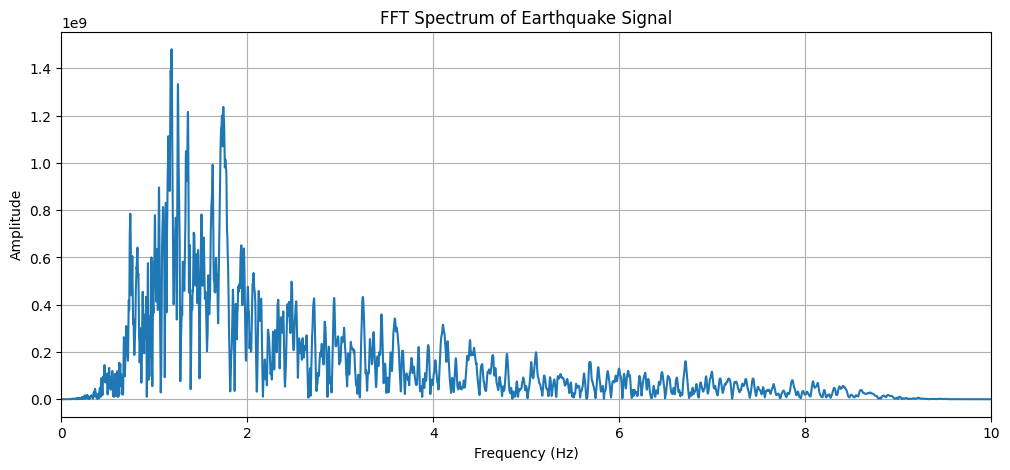

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

y_filtered = tr_filter.data
fs = tr_filter.stats.sampling_rate

# --- FFT ---
N = len(y_filtered)
fft_vals = np.fft.rfft(y_filtered)
fft_freq = np.fft.rfftfreq(N, d=1/fs)

fft_amp = np.abs(fft_vals)

plt.figure(figsize=(12,5))
plt.plot(fft_freq, fft_amp)
plt.title("FFT Spectrum of Earthquake Signal")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.xlim(0, fs/2)  # frekuensi hingga Nyquist
plt.grid(True)
plt.show()

**Penjelasan Kode:**
Kode ini digunakan untuk menganalisis spektrum frekuensi sinyal gempa menggunakan metode Fast Fourier Transform (FFT).

**Fungsi Utama:**
Grafik FFT digunakan untuk mengidentifikasi frekuensi dominan (peak frequency), yaitu frekuensi dengan amplitudo terbesar yang menunjukkan tempat energi getaran gempa paling terkonsentrasi.


In [63]:
import numpy as np

peak_idx = np.argmax(fft_amp)     #M encari indeks amplitudo terbesar pada spektrum FFT
peak_freq = fft_freq[peak_idx]    # Mengambil nilai frekuensi yang memiliki amplitudo terbesar tersebut
peak_amp  = fft_amp[peak_idx]     # Mengambil nilai amplitudo maksimum pada frekuensi dominan

print("Peak Frequency:", peak_freq, "Hz")
print("Peak Amplitude:", peak_amp)

Peak Frequency: 1.1863636363636363 Hz
Peak Amplitude: 1481005679.1552424


**Penjelasa Kode:** Kode ini digunakan untuk menentukan frekuensi dominan (peak frequency) pada hasil analisis FFT sinyal gempa.

**Fungsi Utama:**
Frekuensi dominan menunjukkan frekuensi utama tempat energi sinyal gempa terkonsentrasi. Nilai ini penting untuk membedakan karakteristik getaran lemah, sedang, dan kuat dalam analisis seismik.

In [64]:
import numpy as np

# Energi sinyal (total)
energy_total = np.sum(y_filtered**2)

# Power sinyal
power_signal = np.mean(y_filtered**2)

print("Energy:", energy_total)
print("Power :", power_signal)

# Misal y_filtered sudah ada
# Normalisasi ke rentang [-1, 1]
y_norm = y_filtered / np.max(np.abs(y_filtered))

# Energi sinyal (total)
energy_total = np.sum(y_norm**2)

# Power sinyal
power_signal = np.mean(y_norm**2)

print("Energy (normalisasi):", energy_total)
print("Power (normalisasi):", power_signal)

Energy: 6.310302485575565e+16
Power : 4780532186042.095
Energy (normalisasi): 61.28714027769998
Power (normalisasi): 0.004642965172553029


**Penjelasan Kode:**
Kode ini digunakan untuk menghitung energi dan power sinyal gempa, baik sebelum maupun setelah normalisasi.

**Fungsi Utama**
Nilai power hasil normalisasi digunakan sebagai dasar klasifikasi tingkat getaran gempa (lemah, sedang, atau kuat), sedangkan energi menunjukkan akumulasi total kekuatan getaran.

In [65]:
if power_signal < 0.01:
    level = "Lemah"
elif power_signal < 0.05:
    level = "Sedang"
else:
    level = "Kuat"

print("Tingkat Getaran:", level)

Tingkat Getaran: Lemah


**Penjelasan Kode:**
Kode ini digunakan untuk mengklasifikasikan tingkat kekuatan getaran gempa berdasarkan nilai power sinyal hasil normalisasi.

**Fungsi Utama:**
Klasifikasi ini memberikan indikasi awal kekuatan gempa berdasarkan energi sinyal, sehingga memudahkan interpretasi hasil analisis FFT, PSD, dan energi secara keseluruhan.

**Kesimpulan :** Perbandingan hasil antara FFT dan PSD
Pada analisis FFT ini, kita melihat komponen frekuensi yang ada dalam sinyal dan melihat seberapa besar energi amplitudo sinyal pada tiap frekuensi. Hasil analisis ini menunjukkan adanya frekuensi dominan sebesar 1.18 Hz, menunjukkan energi terbesar dari getaran tersebut, adapun amplitudo tertinggi mencapai 148.100 sehingga frekuensi ini menanadakan besarnya kontribusi frekuensi terhadap bentuk keseluruhan sinyal.

Kami juga melakukan perhitungan mengenai energi dan power untuk melakukan klasifikasi untuk gempa tersebut masuk ke dalam gempa yang rendah, sedang, atau kuat. Energi sinyal setelah dinormalisasi sebesar 61.287 dan power sebesar 0.00464 yang menunjukkan adanya energi yang dihasilkan getaran saat terjadi, yang dimana semakin besar nilainya akan semakin kuat juga getaran pada gempa yang terjadi dan power ini menggambarkan tingkat kestabilan kekuatan sinyal sepanjang rekaman.

DATA WAVEFORM INDONESIA

In [66]:
import os
import numpy as np
import matplotlib.pyplot as plt
from obspy import read, UTCDateTime
from scipy.signal import welch

def basic_stats(tr):
    data = tr.data.astype(float)
    return {
        "npts": tr.stats.npts,
        "fs": tr.stats.sampling_rate, #sampling rate
        "duration_s": tr.stats.npts / tr.stats.sampling_rate, #menunjukkan durasi
        "min": np.min(data), #nilai min amplitudo
        "max": np.max(data), #nilai max amplitudo
        "mean": np.mean(data),
        "std": np.std(data), #men
    }

def is_clipped(tr, threshold_ratio=0.99):
    d = tr.data.astype(float)
    absmax = np.max(np.abs(d))
    n_close = np.sum(np.isclose(np.abs(d), absmax, atol=1e-8) | (np.abs(d) > absmax * threshold_ratio))
    frac = n_close / len(d)
    return frac > 0.001, frac

def estimate_snr(tr, pre_pick_sec=10.0, event_sec=20.0):
    n = tr.stats.npts
    fs = tr.stats.sampling_rate
    if n < int(fs*(pre_pick_sec+event_sec+1)):
        mid = n//2
        noise = tr.data[:mid]
        signal = tr.data[mid:]
    else:
        noise = tr.data[:int(fs*pre_pick_sec)]
        signal = tr.data[int(fs*pre_pick_sec):int(fs*(pre_pick_sec+event_sec))]
    noise_rms = np.sqrt(np.mean(noise**2)) + 1e-12
    signal_rms = np.sqrt(np.mean(signal**2)) + 1e-12
    return 20*np.log10(signal_rms / noise_rms)

def plot_spectrum(tr, ax=None):
    f, Pxx = welch(tr.data, fs=tr.stats.sampling_rate, nperseg=2048)
    if ax is None:
        plt.semilogy(f, Pxx)
        plt.xlabel("Hz"); plt.ylabel("PSD")
    else:
        ax.semilogy(f, Pxx)
        ax.set_xlabel("Hz"); ax.set_ylabel("PSD")

sac_files = [
    "/content/II.KAPI.00.BH1.M.2025.328.013028.SAC",
    "/content/II.KAPI.00.BH2.M.2025.328.013028.SAC",
    "/content/II.KAPI.00.BHZ.M.2025.328.013028.SAC",
    "/content/II.KAPI.10.BH1.M.2025.328.013028.SAC",
    "/content/II.KAPI.10.BH2.M.2025.328.013028.SAC",
    "/content/II.KAPI.10.BHZ.M.2025.328.013028.SAC"
]

results = []
for fpath in sac_files:
    if not os.path.exists(fpath):
        print("File not found:", fpath)
        continue
    st = read(fpath)
    tr = st[0]
    stats = basic_stats(tr)
    clipped, frac_clipped = is_clipped(tr)
    snr_db = estimate_snr(tr)
    results.append({
        "file": fpath,
        "channel": tr.stats.channel,
        "location": tr.stats.location,
        **stats,
        "clipped": clipped,
        "frac_clipped": frac_clipped,
        "snr_db": snr_db
    })


                                            file location channel    fs  \
0  /content/II.KAPI.00.BH1.M.2025.328.013028.SAC       00     BH1  40.0   
1  /content/II.KAPI.00.BH2.M.2025.328.013028.SAC       00     BH2  40.0   
2  /content/II.KAPI.00.BHZ.M.2025.328.013028.SAC       00     BHZ  40.0   
3  /content/II.KAPI.10.BH1.M.2025.328.013028.SAC       10     BH1  40.0   
4  /content/II.KAPI.10.BH2.M.2025.328.013028.SAC       10     BH2  40.0   
5  /content/II.KAPI.10.BHZ.M.2025.328.013028.SAC       10     BHZ  40.0   

   duration_s     min     max         std  clipped  frac_clipped    snr_db  
0       660.0 -2146.0    30.0  132.604875    False      0.000038  0.102549  
1       660.0  -242.0  1729.0  149.871219    False      0.000038  0.174889  
2       660.0 -1306.0   505.0  164.565442    False      0.000038  0.525774  
3       660.0  -652.0  2425.0  176.328671    False      0.000038 -0.345545  
4       660.0  -345.0  3149.0  182.082156    False      0.000038 -0.064345  
5       660.

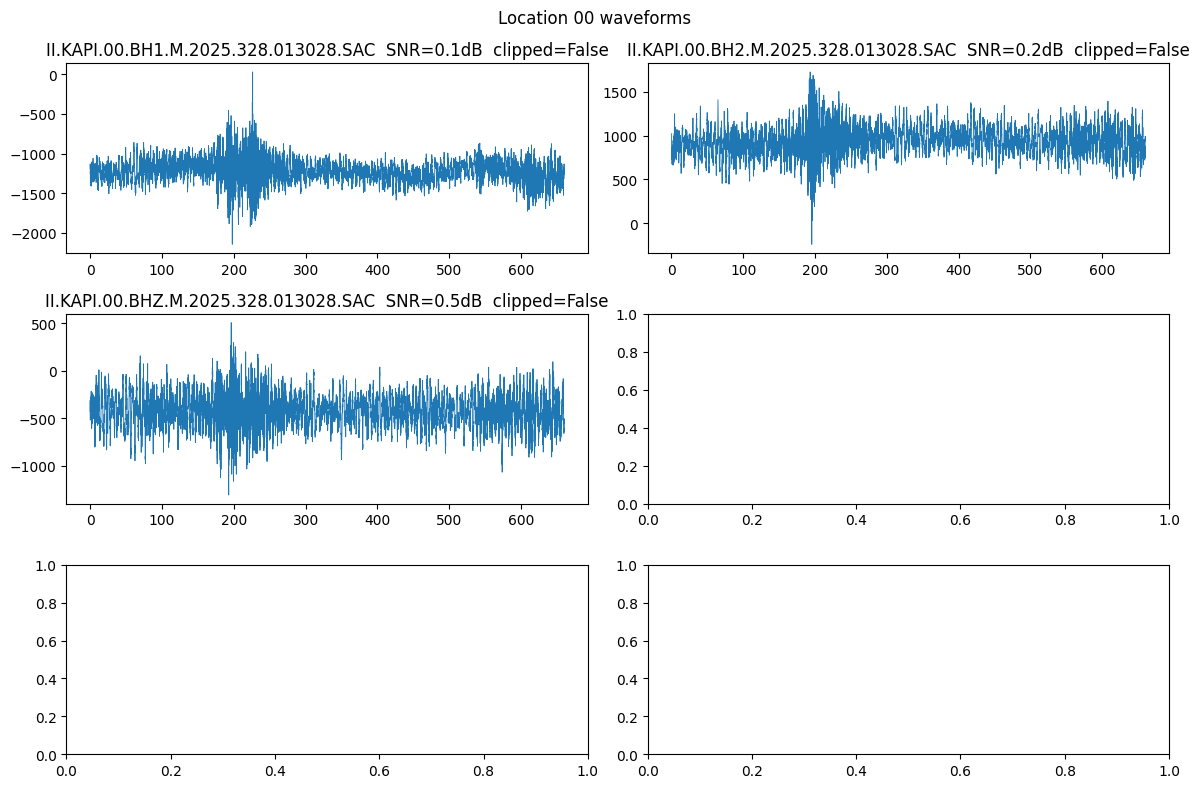

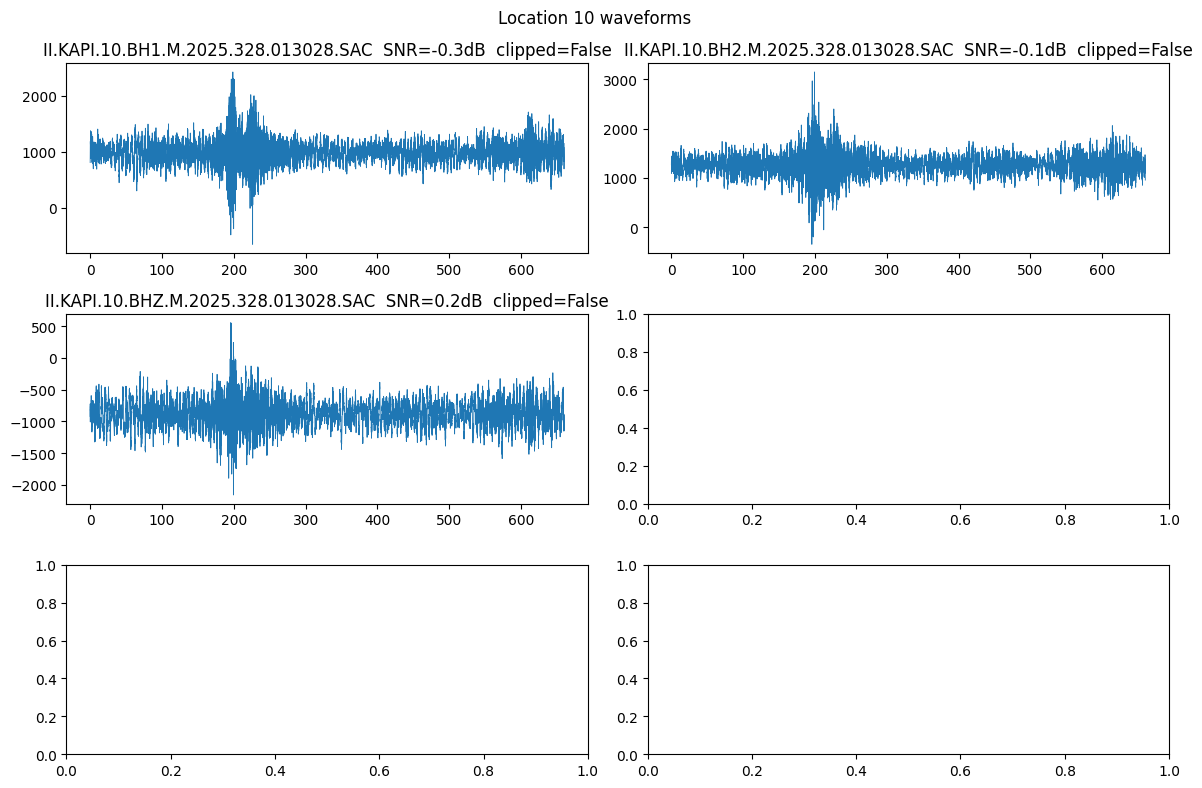

In [67]:
import pandas as pd
df = pd.DataFrame(results)
print(df[["file","location","channel","fs","duration_s","min","max","std","clipped","frac_clipped","snr_db"]])

locations = sorted(df['location'].unique())
for loc in locations:
    sel = df[df['location']==loc]
    if sel.empty: continue
    fig, axes = plt.subplots(3,2, figsize=(12,8))
    axes = axes.flatten()
    for idx, (i, row) in enumerate(sel.iterrows()):
        tr = read(row['file'])[0]
        ax = axes[idx]
        t = np.arange(tr.stats.npts)/tr.stats.sampling_rate
        ax.plot(t, tr.data, linewidth=0.6)
        ax.set_title(f"{os.path.basename(row['file'])}  SNR={row['snr_db']:.1f}dB  clipped={row['clipped']}")
    plt.suptitle(f"Location {loc} waveforms")
    plt.tight_layout()
    plt.show()

                                            file location channel    fs  \
0  /content/II.KAPI.00.BH1.M.2025.328.013028.SAC       00     BH1  40.0   
1  /content/II.KAPI.00.BH2.M.2025.328.013028.SAC       00     BH2  40.0   
2  /content/II.KAPI.00.BHZ.M.2025.328.013028.SAC       00     BHZ  40.0   
3  /content/II.KAPI.10.BH1.M.2025.328.013028.SAC       10     BH1  40.0   
4  /content/II.KAPI.10.BH2.M.2025.328.013028.SAC       10     BH2  40.0   
5  /content/II.KAPI.10.BHZ.M.2025.328.013028.SAC       10     BHZ  40.0   

   duration_s     min     max         std  clipped  frac_clipped    snr_db  
0       660.0 -2146.0    30.0  132.604875    False      0.000038  0.102549  
1       660.0  -242.0  1729.0  149.871219    False      0.000038  0.174889  
2       660.0 -1306.0   505.0  164.565442    False      0.000038  0.525774  
3       660.0  -652.0  2425.0  176.328671    False      0.000038 -0.345545  
4       660.0  -345.0  3149.0  182.082156    False      0.000038 -0.064345  
5       660.

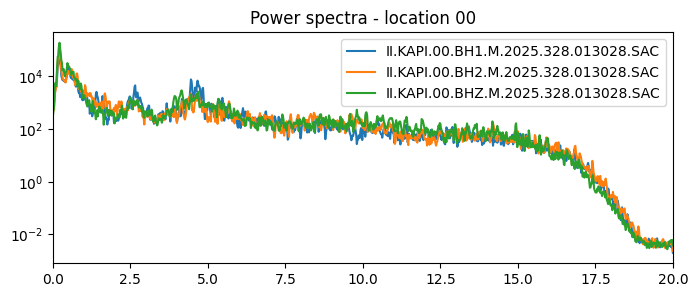

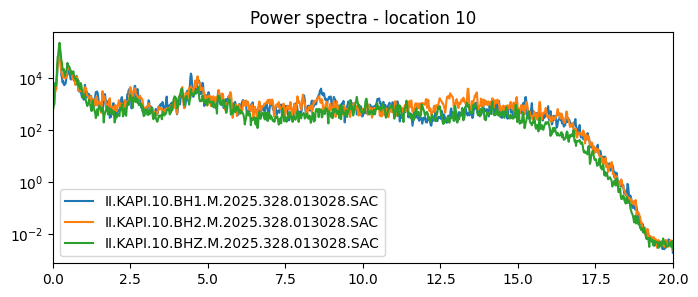

In [68]:
import pandas as pd
df = pd.DataFrame(results)
print(df[["file","location","channel","fs","duration_s","min","max","std","clipped","frac_clipped","snr_db"]])

locations = sorted(df['location'].unique())
for loc in locations:
    sel = df[df['location']==loc]
    if sel.empty: continue
    fig, ax = plt.subplots(1,1, figsize=(8,3))
    for i, row in sel.iterrows():
        tr = read(row['file'])[0]
        f, Pxx = welch(tr.data, fs=tr.stats.sampling_rate, nperseg=2048)
        ax.semilogy(f, Pxx, label=os.path.basename(row['file']))
    ax.set_xlim(0, tr.stats.sampling_rate/2)
    ax.legend()
    ax.set_title(f"Power spectra - location {loc}")
    plt.show()

In [69]:
loc_scores = {}
for loc in locations:
    sel = df[df['location']==loc]
    if sel.empty: continue
    score = sel['snr_db'].median() - (sel['frac_clipped'].median()*1000)
    loc_scores[loc] = score
print("Location scores:", loc_scores)
best_loc = max(loc_scores, key=loc_scores.get)
print("Recommended location:", best_loc)
print("Recommended files (3-component):")
print(df[df['location']==best_loc]['file'].tolist())

Location scores: {'00': 0.1370100315773126, '10': -0.10222417748335635}
Recommended location: 00
Recommended files (3-component):
['/content/II.KAPI.00.BH1.M.2025.328.013028.SAC', '/content/II.KAPI.00.BH2.M.2025.328.013028.SAC', '/content/II.KAPI.00.BHZ.M.2025.328.013028.SAC']


/usr/local/lib/python3.12/dist-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (20) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


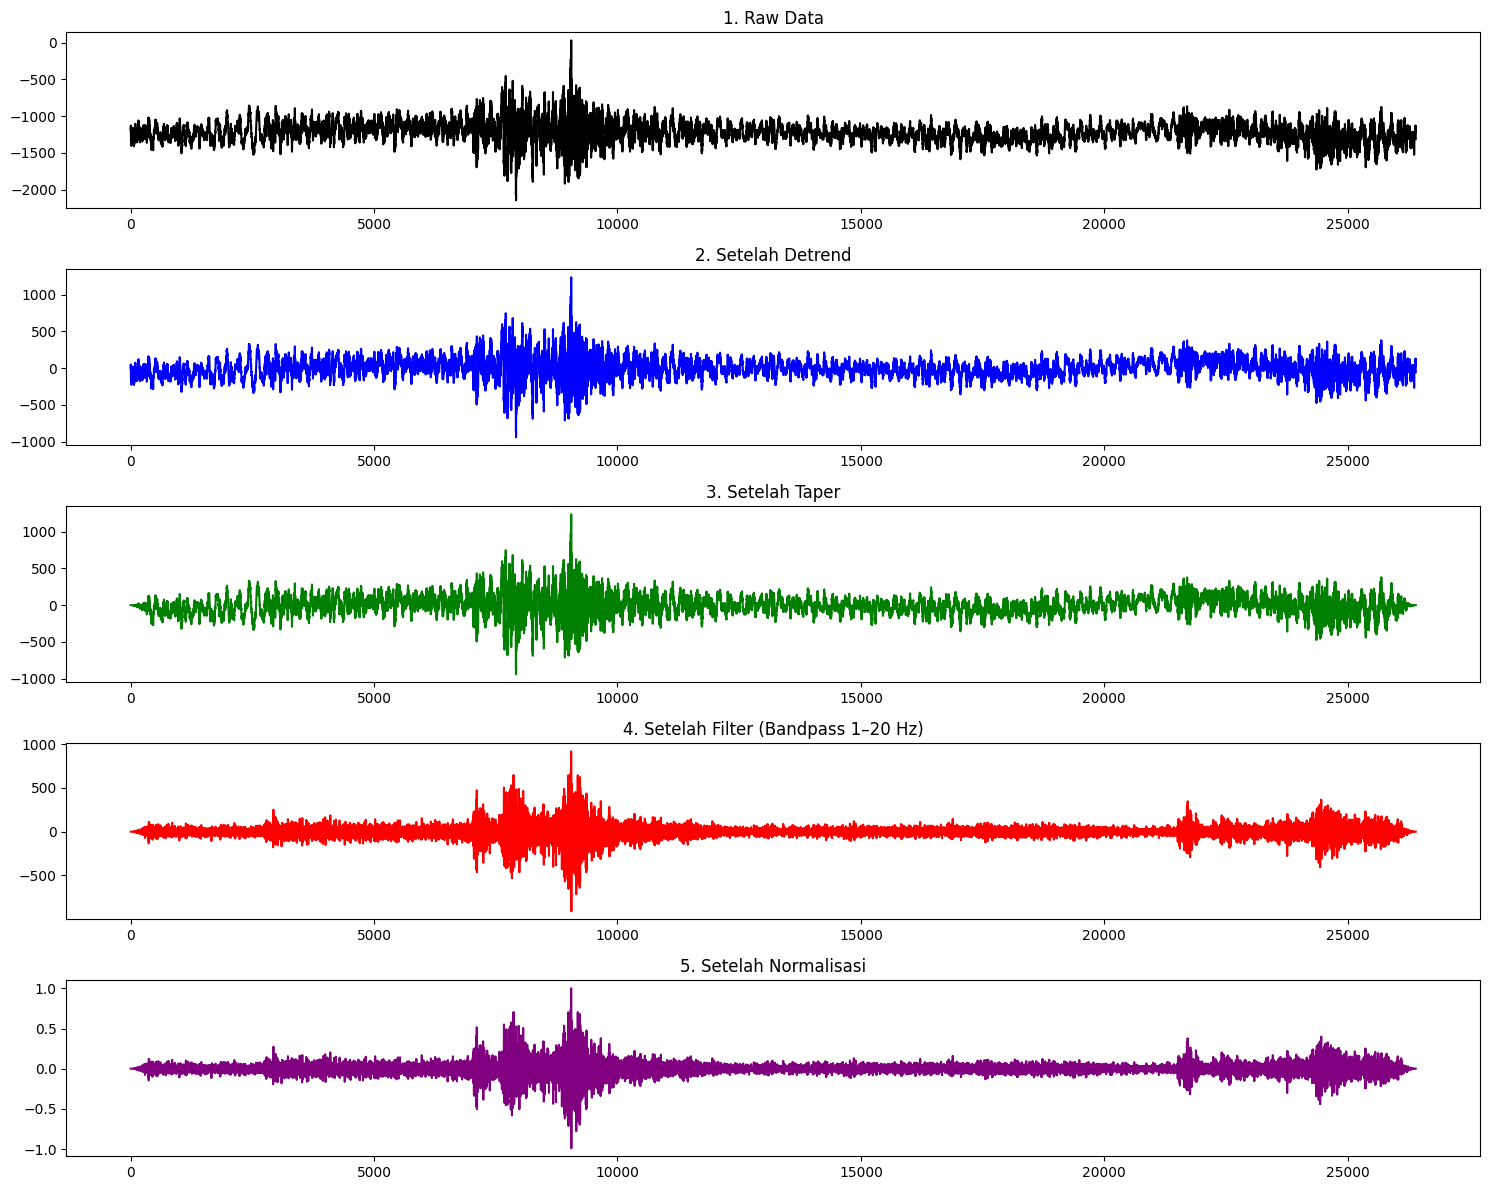

In [70]:
import matplotlib.pyplot as plt
from obspy import read
import numpy as np

# --- 1. Load data ---
tr_raw = read("/content/II.KAPI.00.BH1.M.2025.328.013028.SAC")[0]

# Copy agar tidak overwrite
tr_detrend = tr_raw.copy()
tr_taper   = tr_raw.copy()
tr_filter  = tr_raw.copy()
tr_norm    = tr_raw.copy()

# --- 2. Apply processing step by step ---
tr_detrend.detrend("linear")
tr_taper.detrend("linear")
tr_taper.taper(max_percentage=0.02, type="cosine")

tr_filter.detrend("linear")
tr_filter.taper(max_percentage=0.02, type="cosine")
tr_filter.filter("bandpass", freqmin=1, freqmax=20)

tr_norm.detrend("linear")
tr_norm.taper(max_percentage=0.02, type="cosine")
tr_norm.filter("bandpass", freqmin=1, freqmax=20)
data_norm = tr_norm.data / np.max(np.abs(tr_norm.data))


# --- 3. Plot all steps ---
plt.figure(figsize=(15, 12))

# Raw
plt.subplot(5,1,1)
plt.plot(tr_raw.data, color="black")
plt.title("1. Raw Data")

# Detrend
plt.subplot(5,1,2)
plt.plot(tr_detrend.data, color="blue")
plt.title("2. Setelah Detrend")

# Taper
plt.subplot(5,1,3)
plt.plot(tr_taper.data, color="green")
plt.title("3. Setelah Taper")

# Filter
plt.subplot(5,1,4)
plt.plot(tr_filter.data, color="red")
plt.title("4. Setelah Filter (Bandpass 1–20 Hz)")

# Normalisasi
plt.subplot(5,1,5)
plt.plot(data_norm, color="purple")
plt.title("5. Setelah Normalisasi")
plt.tight_layout()
plt.show()


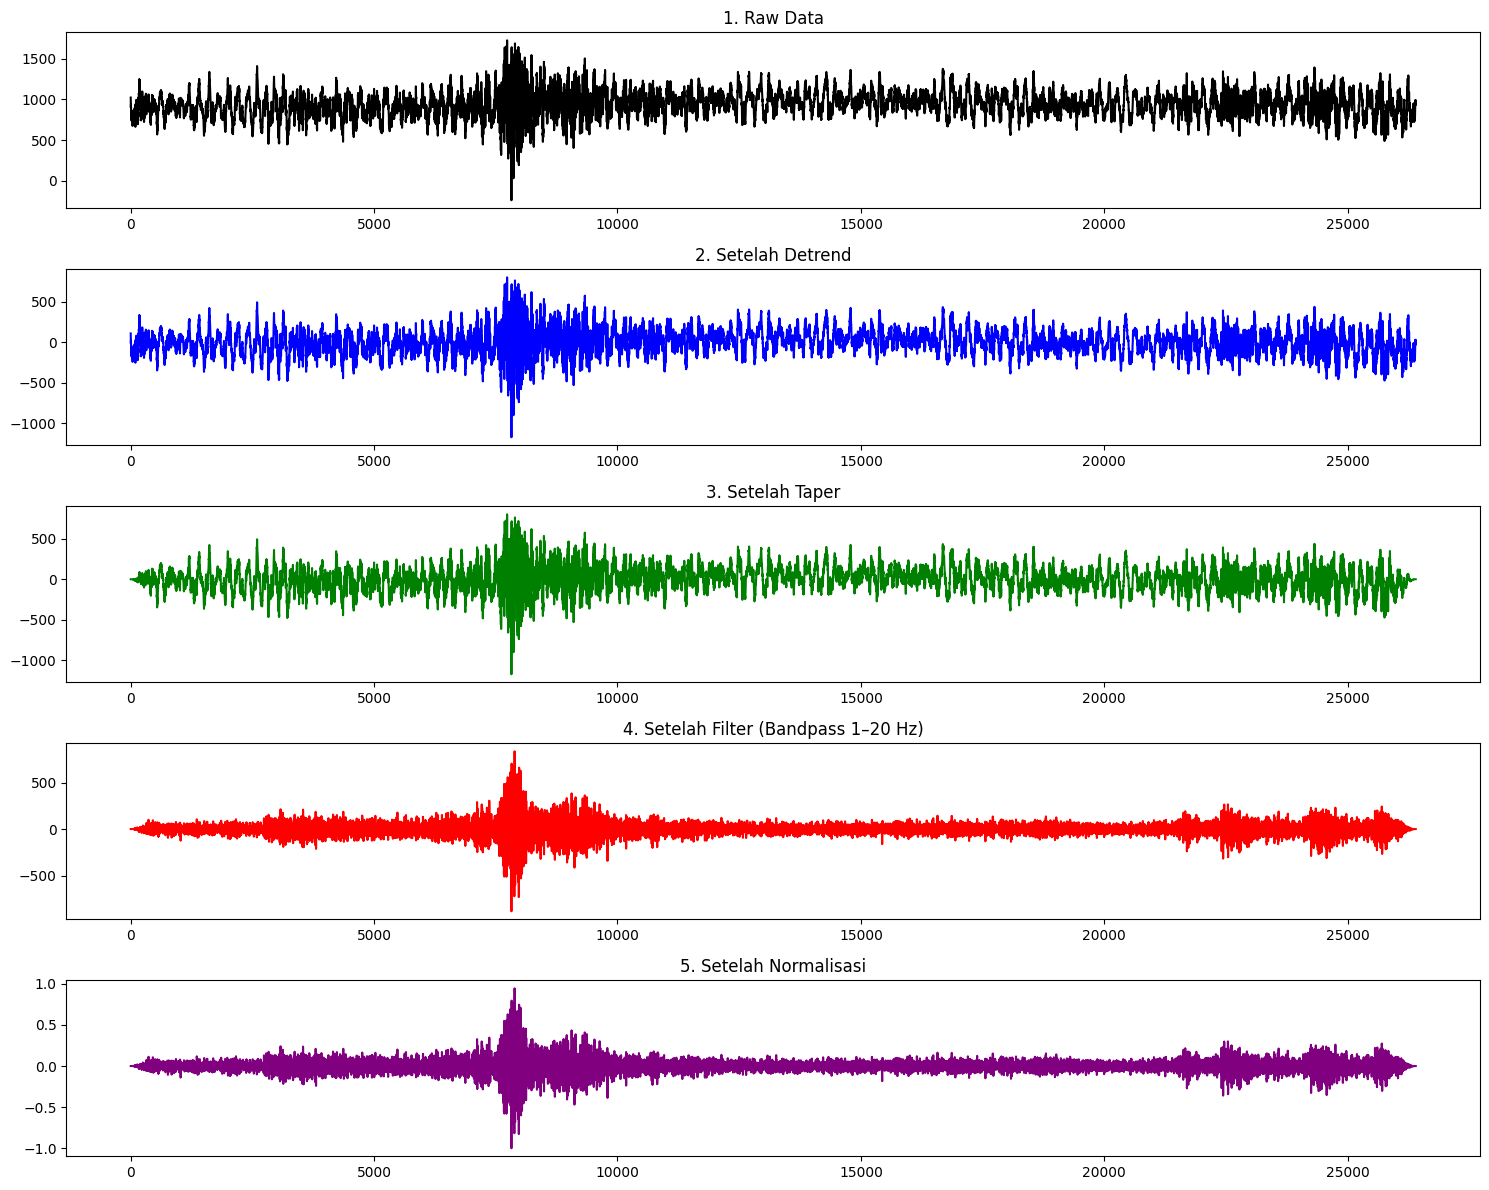

In [71]:
import matplotlib.pyplot as plt
from obspy import read
import numpy as np

# --- 1. Load data ---
tr_raw = read("/content/II.KAPI.00.BH2.M.2025.328.013028.SAC")[0]

# Copy agar tidak overwrite
tr_detrend = tr_raw.copy()
tr_taper   = tr_raw.copy()
tr_filter  = tr_raw.copy()
tr_norm    = tr_raw.copy()

# --- 2. Apply processing step by step ---
tr_detrend.detrend("linear")
tr_taper.detrend("linear")
tr_taper.taper(max_percentage=0.02, type="cosine")

tr_filter.detrend("linear")
tr_filter.taper(max_percentage=0.02, type="cosine")
tr_filter.filter("bandpass", freqmin=1, freqmax=20)

tr_norm.detrend("linear")
tr_norm.taper(max_percentage=0.02, type="cosine")
tr_norm.filter("bandpass", freqmin=1, freqmax=20)
data_norm = tr_norm.data / np.max(np.abs(tr_norm.data))


# --- 3. Plot all steps ---
plt.figure(figsize=(15, 12))

# Raw
plt.subplot(5,1,1)
plt.plot(tr_raw.data, color="black")
plt.title("1. Raw Data")

# Detrend
plt.subplot(5,1,2)
plt.plot(tr_detrend.data, color="blue")
plt.title("2. Setelah Detrend")

# Taper
plt.subplot(5,1,3)
plt.plot(tr_taper.data, color="green")
plt.title("3. Setelah Taper")

# Filter
plt.subplot(5,1,4)
plt.plot(tr_filter.data, color="red")
plt.title("4. Setelah Filter (Bandpass 1–20 Hz)")

# Normalisasi
plt.subplot(5,1,5)
plt.plot(data_norm, color="purple")
plt.title("5. Setelah Normalisasi")
plt.tight_layout()
plt.show()



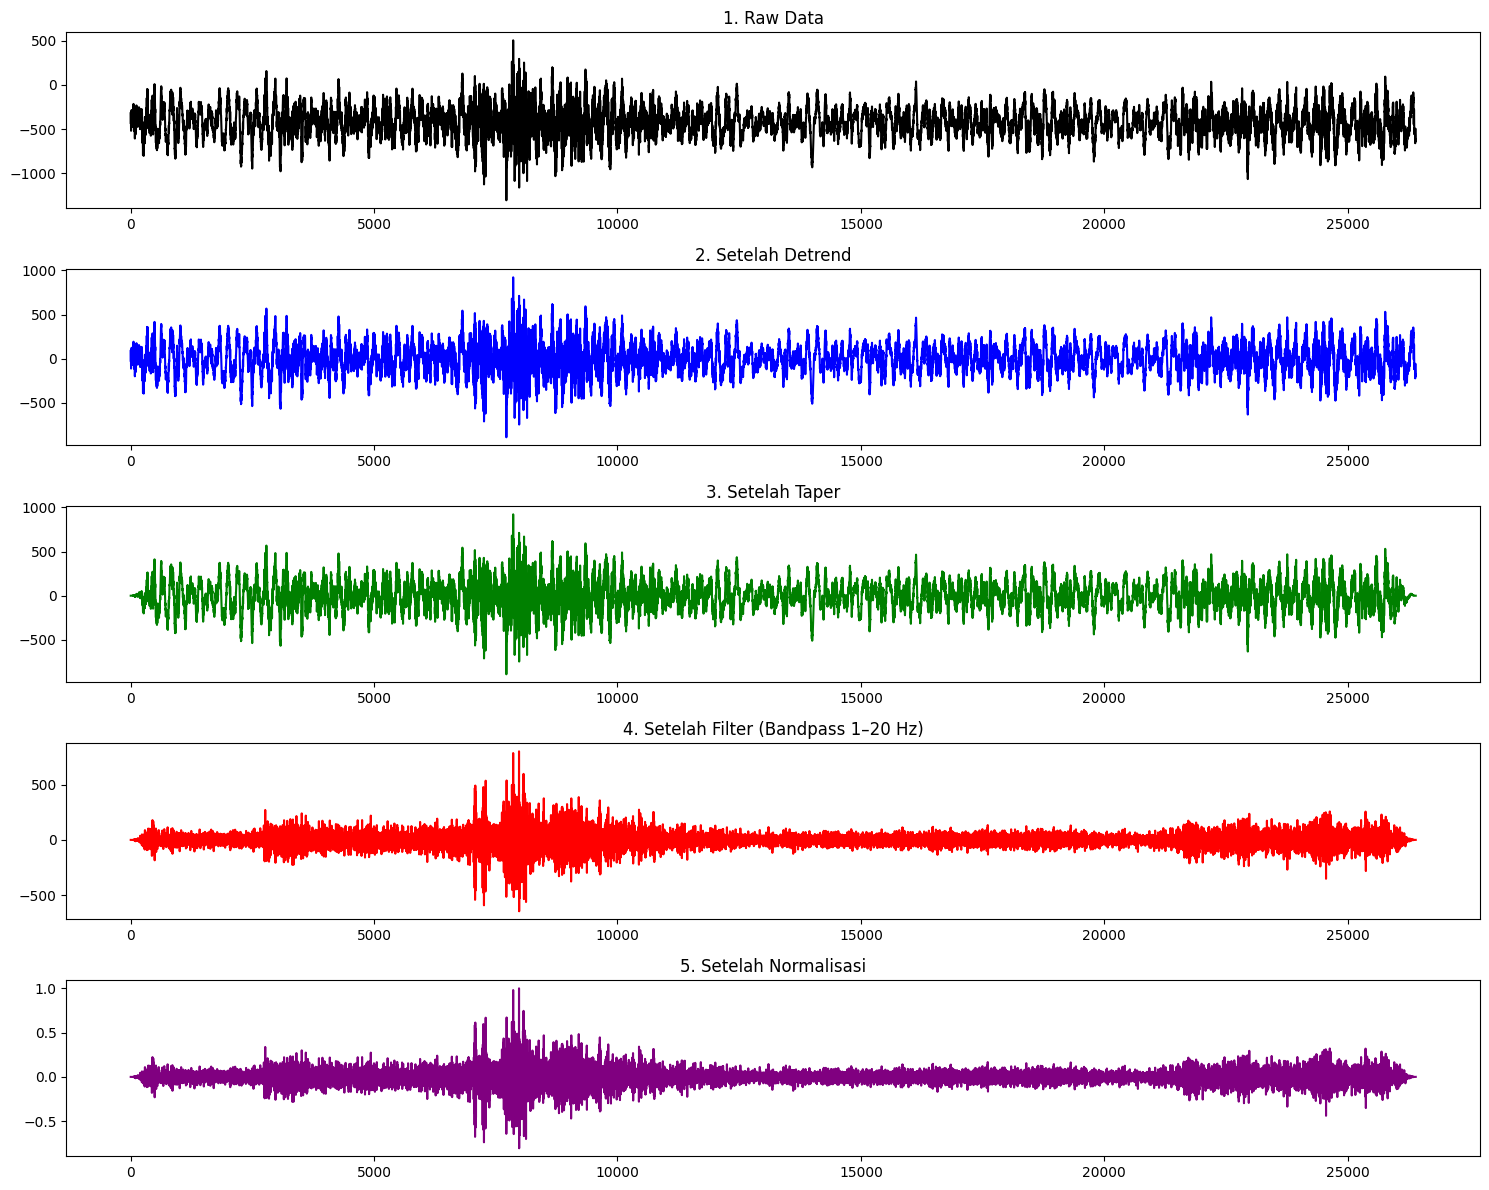

In [72]:
import matplotlib.pyplot as plt
from obspy import read
import numpy as np

# --- 1. Load data ---
tr_raw = read("/content/II.KAPI.00.BHZ.M.2025.328.013028.SAC")[0]

# Copy agar tidak overwrite
tr_detrend = tr_raw.copy()
tr_taper   = tr_raw.copy()
tr_filter  = tr_raw.copy()
tr_norm    = tr_raw.copy()

# --- 2. Apply processing step by step ---
tr_detrend.detrend("linear")
tr_taper.detrend("linear")
tr_taper.taper(max_percentage=0.02, type="cosine")

tr_filter.detrend("linear")
tr_filter.taper(max_percentage=0.02, type="cosine")
tr_filter.filter("bandpass", freqmin=1, freqmax=20)

tr_norm.detrend("linear")
tr_norm.taper(max_percentage=0.02, type="cosine")
tr_norm.filter("bandpass", freqmin=1, freqmax=20)
data_norm = tr_norm.data / np.max(np.abs(tr_norm.data))


# --- 3. Plot all steps ---
plt.figure(figsize=(15, 12))

# Raw
plt.subplot(5,1,1)
plt.plot(tr_raw.data, color="black")
plt.title("1. Raw Data")

# Detrend
plt.subplot(5,1,2)
plt.plot(tr_detrend.data, color="blue")
plt.title("2. Setelah Detrend")

# Taper
plt.subplot(5,1,3)
plt.plot(tr_taper.data, color="green")
plt.title("3. Setelah Taper")

# Filter
plt.subplot(5,1,4)
plt.plot(tr_filter.data, color="red")
plt.title("4. Setelah Filter (Bandpass 1–20 Hz)")

# Normalisasi
plt.subplot(5,1,5)
plt.plot(data_norm, color="purple")
plt.title("5. Setelah Normalisasi")
plt.tight_layout()
plt.show()

In [73]:
data = tr.data
data = data / max(abs(data))
print(tr.data[:10])

[ -924.  -841.  -725.  -824.  -884.  -902. -1004. -1011.  -866.  -815.]


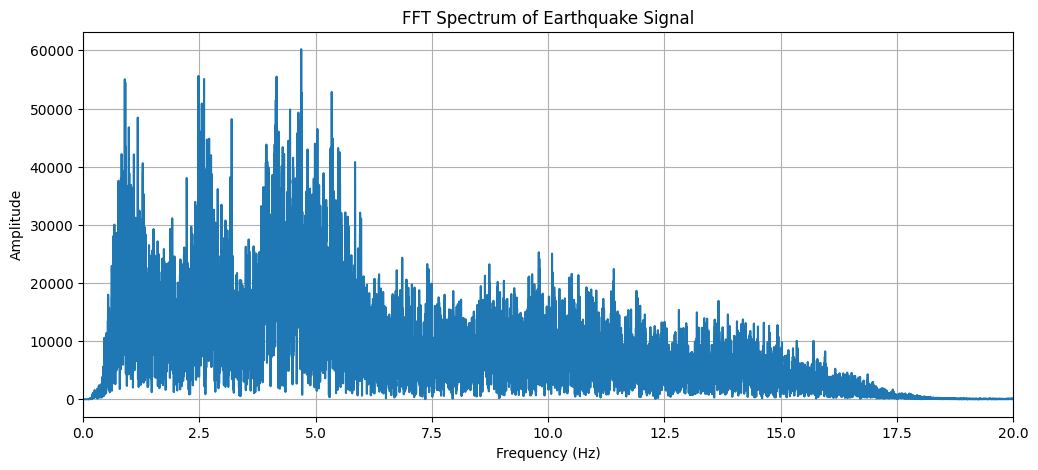

In [74]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

y_filtered = tr_filter.data
fs = tr_filter.stats.sampling_rate

# --- FFT ---
N = len(y_filtered)
fft_vals = np.fft.rfft(y_filtered)
fft_freq = np.fft.rfftfreq(N, d=1/fs)

fft_amp = np.abs(fft_vals)

plt.figure(figsize=(12,5))
plt.plot(fft_freq, fft_amp)
plt.title("FFT Spectrum of Earthquake Signal")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.xlim(0, fs/2)  # frekuensi hingga Nyquist
plt.grid(True)
plt.show()

In [75]:
peak_idx = np.argmax(fft_amp)
peak_freq = fft_freq[peak_idx]
peak_amp  = fft_amp[peak_idx]

print("Peak Frequency:", peak_freq, "Hz")
print("Peak Amplitude:", peak_amp)

Peak Frequency: 4.6893939393939394 Hz
Peak Amplitude: 60197.459349219665


In [76]:
import numpy as np

# Energi sinyal (total)
energy_total = np.sum(y_filtered**2)

# Power sinyal
power_signal = np.mean(y_filtered**2)

print("Energy:", energy_total)
print("Power :", power_signal)

Energy: 127487308.22967112
Power : 4829.064705669361


In [77]:
import numpy as np

# Misal y_filtered sudah ada
# Normalisasi ke rentang [-1, 1]
y_norm = y_filtered / np.max(np.abs(y_filtered))

# Energi sinyal (total)
energy_total = np.sum(y_norm**2)

# Power sinyal
power_signal = np.mean(y_norm**2)

print("Energy (normalisasi):", energy_total)
print("Power (normalisasi):", power_signal)


Energy (normalisasi): 197.76417410903346
Power (normalisasi): 0.007491067201099752


In [78]:
if power_signal < 0.01:
    level = "Lemah"
elif power_signal < 0.05:
    level = "Sedang"
else:
    level = "Kuat"

print("Tingkat Getaran:", level)


Tingkat Getaran: Lemah


Perbandingan hasil antara FFT dan PSD
Pada analisis FFT ini, kita melihat komponen frekuensi yang ada dalam sinyal dan melihat seberapa besar energi amplitudo sinyal pada tiap frekuensi. Hasil analisis ini menunjukkan adanya frekuensi dominan sebesar 4.69 Hz, menunjukkan energi terbesar dari getaran tersebut, adapun amplitudo tertinggi mencapai 60.197 sehingga frekuensi ini menanadakan besarnya kontribusi frekuensi terhadap bentuk keseluruhan sinya.

Kami juga melakukan perhitungan mengenai energi dan power untuk melakukan klasifikasi untuk gempa tersebut masuk ke dalam gempa yang rendah, sedang, atau kuat. Energi sinyal setelah dinormalisasi sebesar 197.76 dan power sebesar 0,000749 yang menunjukkan adanya energi yang dihasilkan getaran saat terjadi, yang dimana semakin besar nilainya akan semakin kuat juga getaran pada gempa yang terjadi dan power ini menggambarkan tingkat kestabilan kekuatan sinyal sepanjang rekaman.

#**WAVEFORM SEDANG**

DATA JEPANG

In [79]:
import os
import numpy as np
import matplotlib.pyplot as plt
from obspy import read, UTCDateTime
from scipy.signal import welch

def basic_stats(tr):
    data = tr.data.astype(float)
    return {
        "npts": tr.stats.npts,
        "fs": tr.stats.sampling_rate, #sampling rate
        "duration_s": tr.stats.npts / tr.stats.sampling_rate, #menunjukkan durasi
        "min": np.min(data), #nilai min amplitudo
        "max": np.max(data), #nilai max amplitudo
        "mean": np.mean(data),
        "std": np.std(data), #men
    }

def is_clipped(tr, threshold_ratio=0.99):
    d = tr.data.astype(float)
    absmax = np.max(np.abs(d))
    n_close = np.sum(np.isclose(np.abs(d), absmax, atol=1e-8) | (np.abs(d) > absmax * threshold_ratio))
    frac = n_close / len(d)
    return frac > 0.001, frac

def estimate_snr(tr, pre_pick_sec=10.0, event_sec=20.0):
    n = tr.stats.npts
    fs = tr.stats.sampling_rate
    if n < int(fs*(pre_pick_sec+event_sec+1)):
        mid = n//2
        noise = tr.data[:mid]
        signal = tr.data[mid:]
    else:
        noise = tr.data[:int(fs*pre_pick_sec)]
        signal = tr.data[int(fs*pre_pick_sec):int(fs*(pre_pick_sec+event_sec))]
    noise_rms = np.sqrt(np.mean(noise**2)) + 1e-12
    signal_rms = np.sqrt(np.mean(signal**2)) + 1e-12
    return 20*np.log10(signal_rms / noise_rms)

def plot_spectrum(tr, ax=None):
    f, Pxx = welch(tr.data, fs=tr.stats.sampling_rate, nperseg=2048)
    if ax is None:
        plt.semilogy(f, Pxx)
        plt.xlabel("Hz"); plt.ylabel("PSD")
    else:
        ax.semilogy(f, Pxx)
        ax.set_xlabel("Hz"); ax.set_ylabel("PSD")

sac_files = [
    "/content/IU.MAJO.00.BH1.M.2025.325.122220.SAC",
    "/content/IU.MAJO.00.BH2.M.2025.325.122220.SAC",
    "/content/IU.MAJO.00.BHZ.M.2025.325.122220.SAC",
    "/content/IU.MAJO.10.BH1.M.2025.325.122220.SAC",
    "/content/IU.MAJO.10.BH2.M.2025.325.122220.SAC",
    "/content/IU.MAJO.10.BHZ.M.2025.325.122220.SAC",
    "/content/IU.MAJO.60.BH1.M.2025.325.122220.SAC",
    "/content/IU.MAJO.60.BH2.M.2025.325.122220.SAC",
    "/content/IU.MAJO.60.BHZ.M.2025.325.122220.SAC"
]

results = []
for fpath in sac_files:
    if not os.path.exists(fpath):
        print("File not found:", fpath)
        continue
    st = read(fpath)
    tr = st[0]
    stats = basic_stats(tr)
    clipped, frac_clipped = is_clipped(tr)
    snr_db = estimate_snr(tr)
    results.append({
        "file": fpath,
        "channel": tr.stats.channel,
        "location": tr.stats.location,
        **stats,
        "clipped": clipped,
        "frac_clipped": frac_clipped,
        "snr_db": snr_db
    })


                                            file location channel    fs  \
0  /content/IU.MAJO.00.BH1.M.2025.325.122220.SAC       00     BH1  40.0   
1  /content/IU.MAJO.00.BH2.M.2025.325.122220.SAC       00     BH2  40.0   
2  /content/IU.MAJO.00.BHZ.M.2025.325.122220.SAC       00     BHZ  40.0   
3  /content/IU.MAJO.10.BH1.M.2025.325.122220.SAC       10     BH1  40.0   
4  /content/IU.MAJO.10.BH2.M.2025.325.122220.SAC       10     BH2  40.0   
5  /content/IU.MAJO.10.BHZ.M.2025.325.122220.SAC       10     BHZ  40.0   
6  /content/IU.MAJO.60.BH1.M.2025.325.122220.SAC       60     BH1  40.0   
7  /content/IU.MAJO.60.BH2.M.2025.325.122220.SAC       60     BH2  40.0   
8  /content/IU.MAJO.60.BHZ.M.2025.325.122220.SAC       60     BHZ  40.0   

   duration_s       min       max           std  clipped  frac_clipped  \
0       660.0  -84791.0   69777.0  11107.950782    False      0.000189   
1       660.0  -58371.0   60004.0  10501.522409    False      0.000189   
2       660.0  -35063.0   3

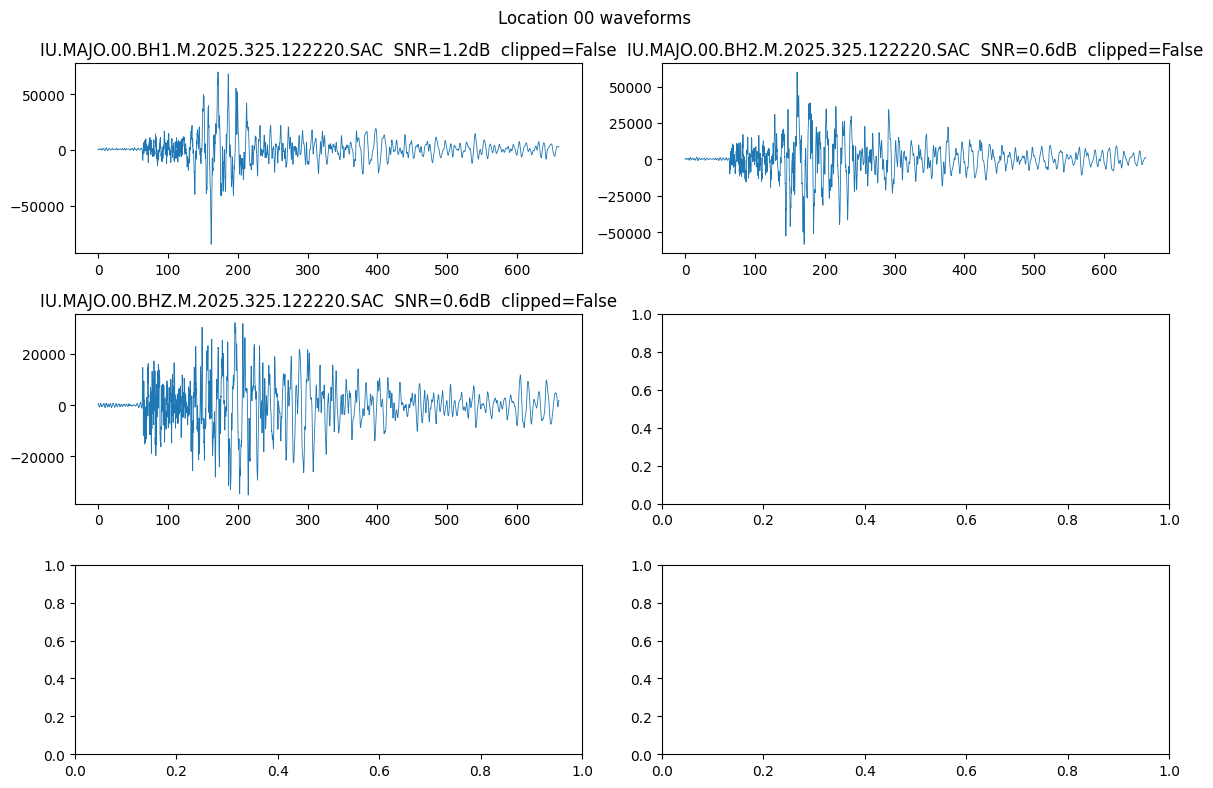

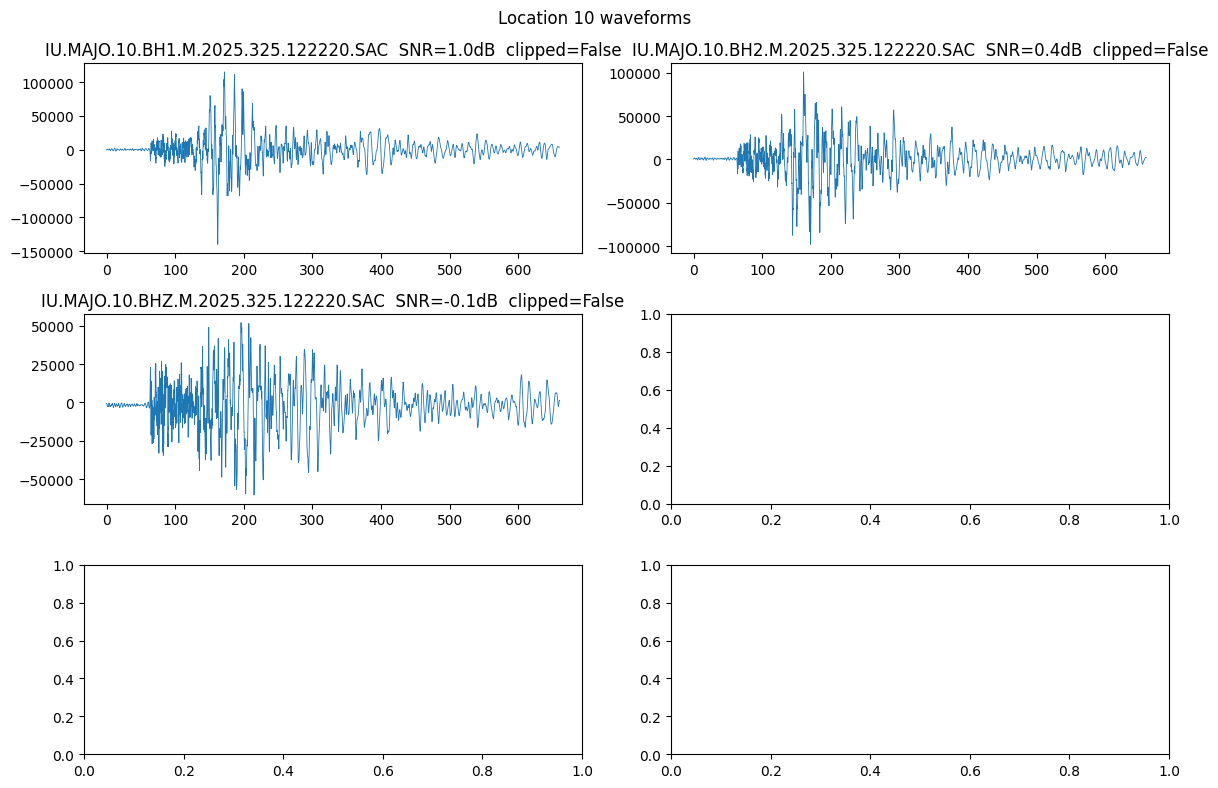

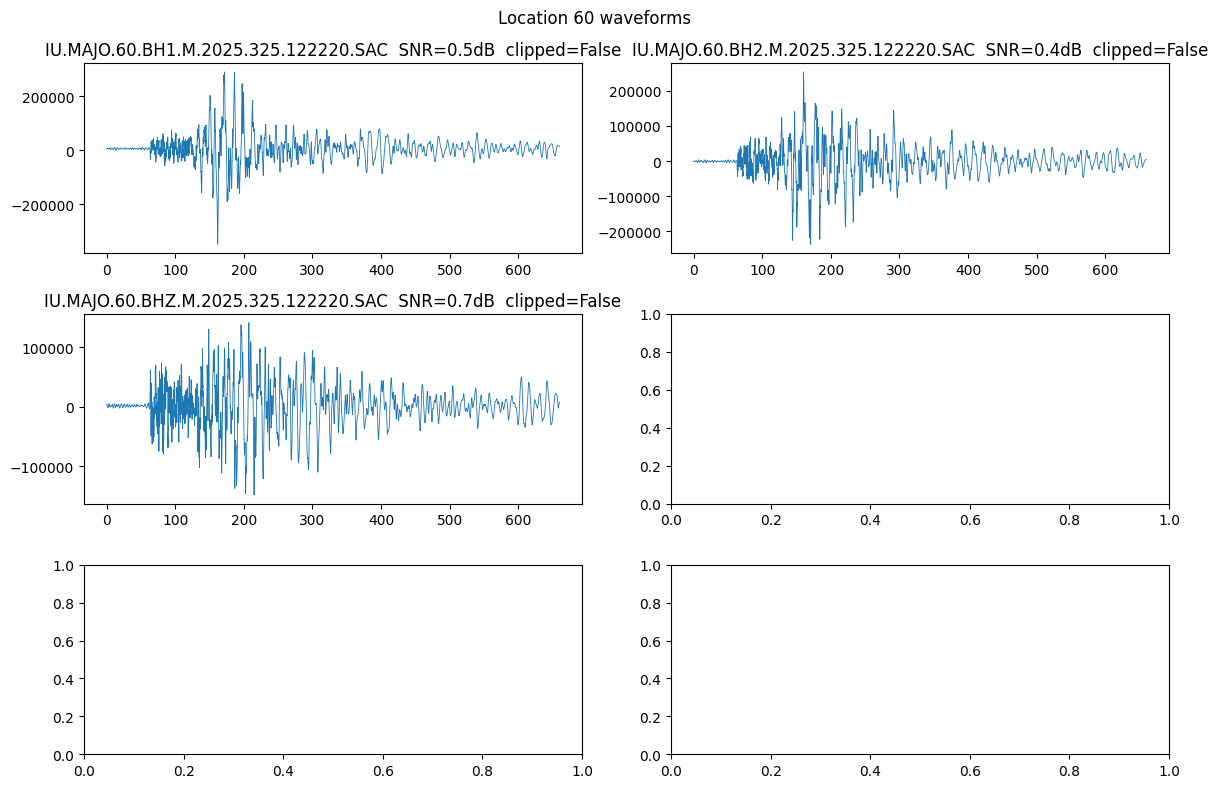

In [80]:
import pandas as pd
df = pd.DataFrame(results)
print(df[["file","location","channel","fs","duration_s","min","max","std","clipped","frac_clipped","snr_db"]])

locations = sorted(df['location'].unique())
for loc in locations:
    sel = df[df['location']==loc]
    if sel.empty: continue
    fig, axes = plt.subplots(3,2, figsize=(12,8))
    axes = axes.flatten()
    for idx, (i, row) in enumerate(sel.iterrows()):
        tr = read(row['file'])[0]
        ax = axes[idx]
        t = np.arange(tr.stats.npts)/tr.stats.sampling_rate
        ax.plot(t, tr.data, linewidth=0.6)
        ax.set_title(f"{os.path.basename(row['file'])}  SNR={row['snr_db']:.1f}dB  clipped={row['clipped']}")
    plt.suptitle(f"Location {loc} waveforms")
    plt.tight_layout()
    plt.show()

                                            file location channel    fs  \
0  /content/IU.MAJO.00.BH1.M.2025.325.122220.SAC       00     BH1  40.0   
1  /content/IU.MAJO.00.BH2.M.2025.325.122220.SAC       00     BH2  40.0   
2  /content/IU.MAJO.00.BHZ.M.2025.325.122220.SAC       00     BHZ  40.0   
3  /content/IU.MAJO.10.BH1.M.2025.325.122220.SAC       10     BH1  40.0   
4  /content/IU.MAJO.10.BH2.M.2025.325.122220.SAC       10     BH2  40.0   
5  /content/IU.MAJO.10.BHZ.M.2025.325.122220.SAC       10     BHZ  40.0   
6  /content/IU.MAJO.60.BH1.M.2025.325.122220.SAC       60     BH1  40.0   
7  /content/IU.MAJO.60.BH2.M.2025.325.122220.SAC       60     BH2  40.0   
8  /content/IU.MAJO.60.BHZ.M.2025.325.122220.SAC       60     BHZ  40.0   

   duration_s       min       max           std  clipped  frac_clipped  \
0       660.0  -84791.0   69777.0  11107.950782    False      0.000189   
1       660.0  -58371.0   60004.0  10501.522409    False      0.000189   
2       660.0  -35063.0   3

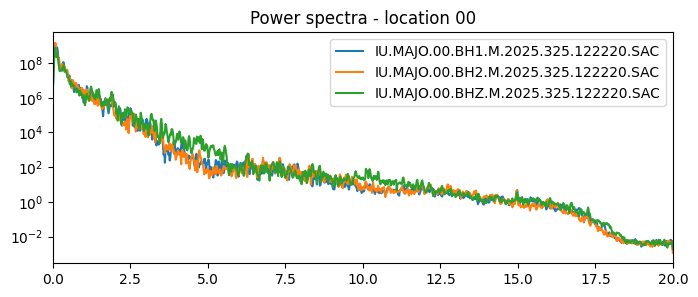

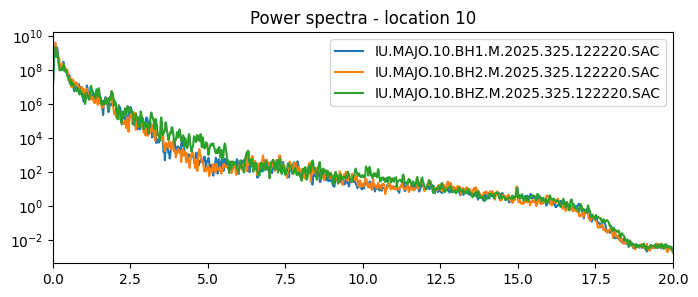

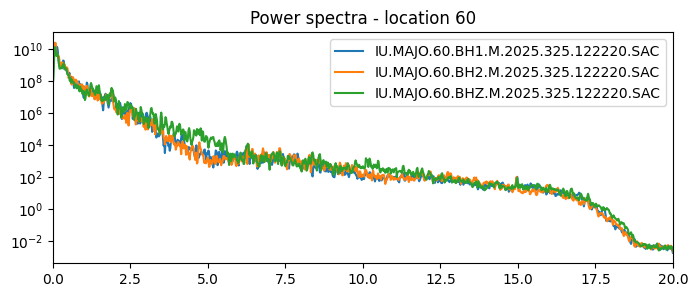

In [81]:
import pandas as pd
df = pd.DataFrame(results)
print(df[["file","location","channel","fs","duration_s","min","max","std","clipped","frac_clipped","snr_db"]])

locations = sorted(df['location'].unique())
for loc in locations:
    sel = df[df['location']==loc]
    if sel.empty: continue
    fig, ax = plt.subplots(1,1, figsize=(8,3))
    for i, row in sel.iterrows():
        tr = read(row['file'])[0]
        f, Pxx = welch(tr.data, fs=tr.stats.sampling_rate, nperseg=2048)
        ax.semilogy(f, Pxx, label=os.path.basename(row['file']))
    ax.set_xlim(0, tr.stats.sampling_rate/2)
    ax.legend()
    ax.set_title(f"Power spectra - location {loc}")
    plt.show()

In [82]:
loc_scores = {}
for loc in locations:
    sel = df[df['location']==loc]
    if sel.empty: continue
    score = sel['snr_db'].median() - (sel['frac_clipped'].median()*1000)
    loc_scores[loc] = score
print("Location scores:", loc_scores)
best_loc = max(loc_scores, key=loc_scores.get)
print("Recommended location:", best_loc)
print("Recommended files (3-component):")
print(df[df['location']==best_loc]['file'].tolist())

Location scores: {'00': 0.41641521273237286, '10': 0.17012890992742596, '60': 0.3304550629673582}
Recommended location: 00
Recommended files (3-component):
['/content/IU.MAJO.00.BH1.M.2025.325.122220.SAC', '/content/IU.MAJO.00.BH2.M.2025.325.122220.SAC', '/content/IU.MAJO.00.BHZ.M.2025.325.122220.SAC']


/usr/local/lib/python3.12/dist-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (20) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


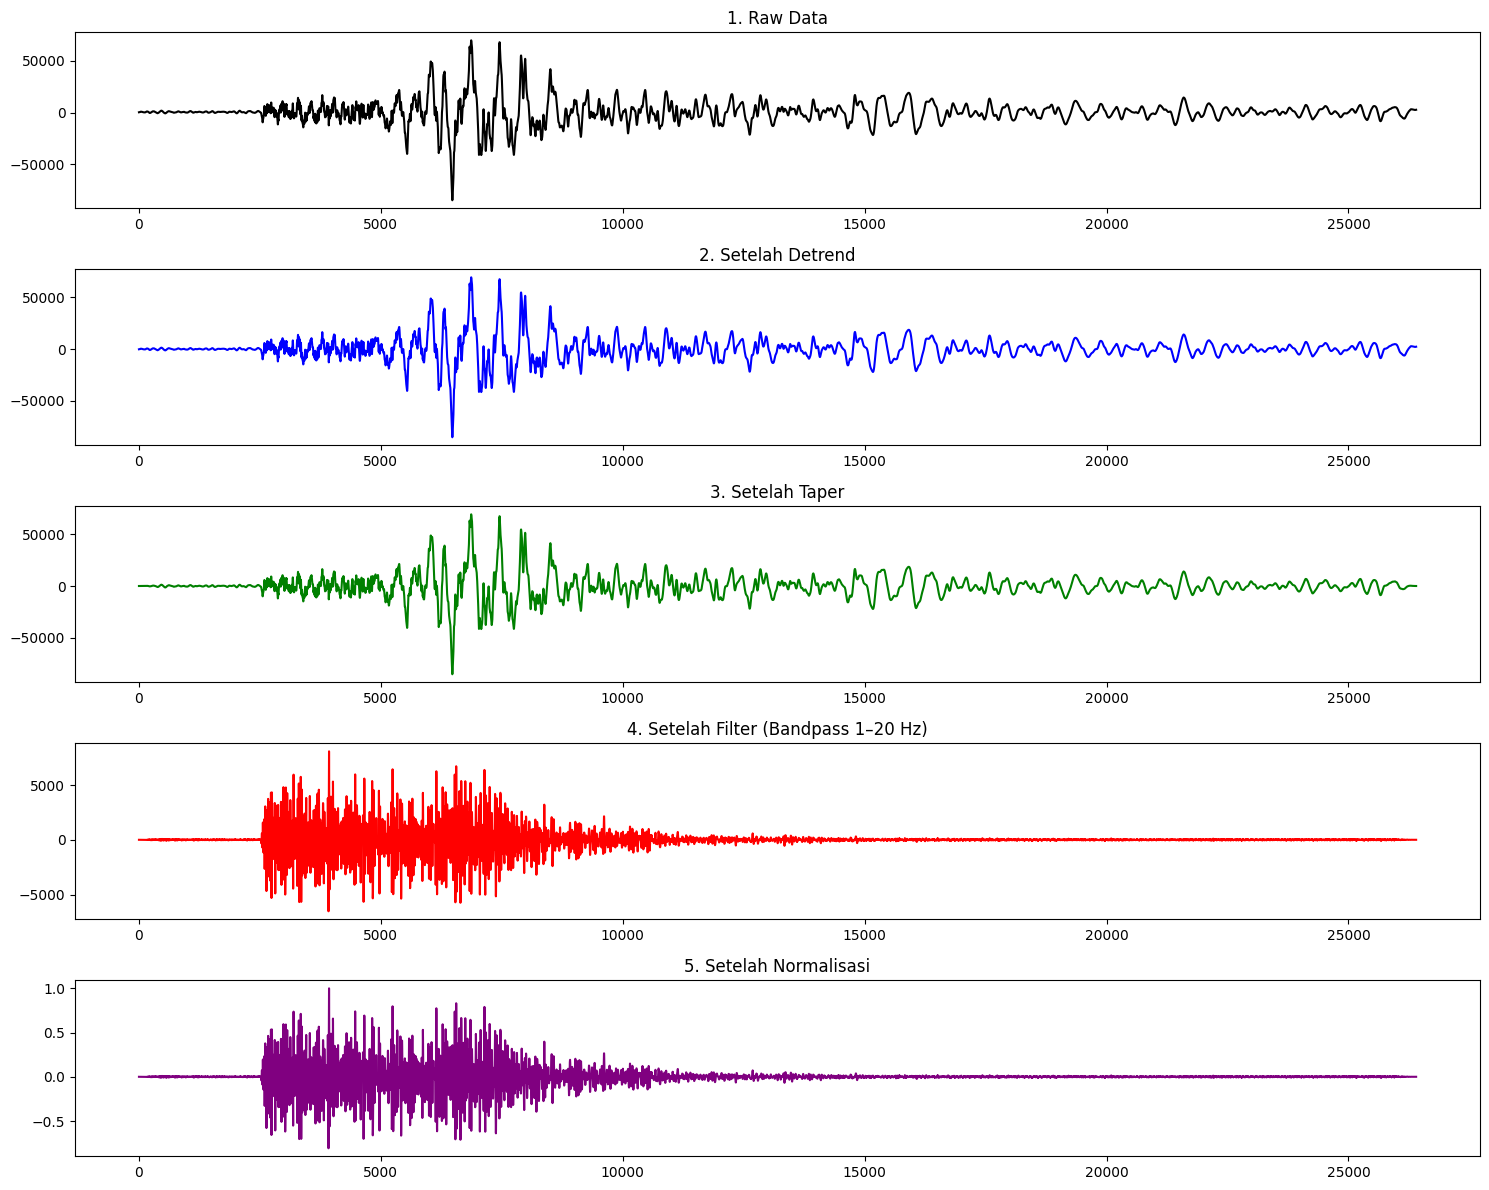

In [83]:
import matplotlib.pyplot as plt
from obspy import read
import numpy as np

# --- 1. Load data ---
tr_raw = read("/content/IU.MAJO.00.BH1.M.2025.325.122220.SAC")[0]

# Copy agar tidak overwrite
tr_detrend = tr_raw.copy()
tr_taper   = tr_raw.copy()
tr_filter  = tr_raw.copy()
tr_norm    = tr_raw.copy()

# --- 2. Apply processing step by step ---
tr_detrend.detrend("linear")
tr_taper.detrend("linear")
tr_taper.taper(max_percentage=0.02, type="cosine")

tr_filter.detrend("linear")
tr_filter.taper(max_percentage=0.02, type="cosine")
tr_filter.filter("bandpass", freqmin=1, freqmax=20)

tr_norm.detrend("linear")
tr_norm.taper(max_percentage=0.02, type="cosine")
tr_norm.filter("bandpass", freqmin=1, freqmax=20)
data_norm = tr_norm.data / np.max(np.abs(tr_norm.data))


# --- 3. Plot all steps ---
plt.figure(figsize=(15, 12))

# Raw
plt.subplot(5,1,1)
plt.plot(tr_raw.data, color="black")
plt.title("1. Raw Data")

# Detrend
plt.subplot(5,1,2)
plt.plot(tr_detrend.data, color="blue")
plt.title("2. Setelah Detrend")

# Taper
plt.subplot(5,1,3)
plt.plot(tr_taper.data, color="green")
plt.title("3. Setelah Taper")

# Filter
plt.subplot(5,1,4)
plt.plot(tr_filter.data, color="red")
plt.title("4. Setelah Filter (Bandpass 1–20 Hz)")

# Normalisasi
plt.subplot(5,1,5)
plt.plot(data_norm, color="purple")
plt.title("5. Setelah Normalisasi")
plt.tight_layout()
plt.show()

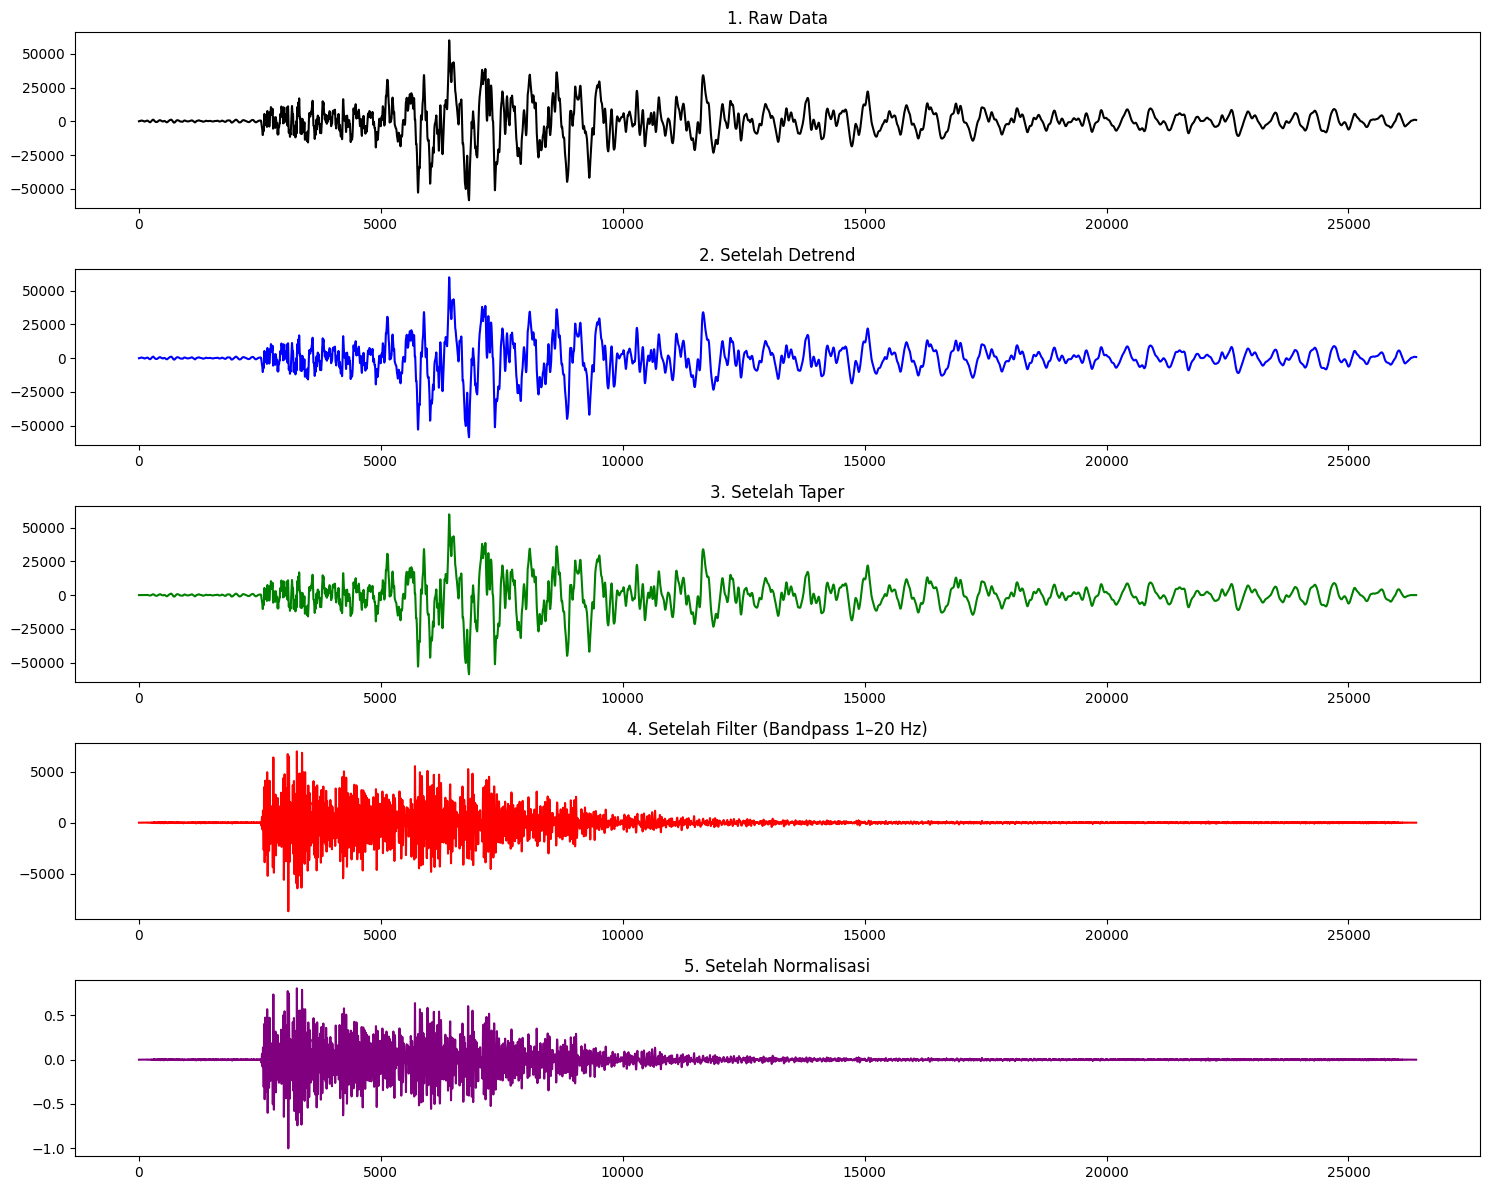

In [84]:
import matplotlib.pyplot as plt
from obspy import read
import numpy as np

# --- 1. Load data ---
tr_raw = read("/content/IU.MAJO.00.BH2.M.2025.325.122220.SAC")[0]

# Copy agar tidak overwrite
tr_detrend = tr_raw.copy()
tr_taper   = tr_raw.copy()
tr_filter  = tr_raw.copy()
tr_norm    = tr_raw.copy()

# --- 2. Apply processing step by step ---
tr_detrend.detrend("linear")
tr_taper.detrend("linear")
tr_taper.taper(max_percentage=0.02, type="cosine")

tr_filter.detrend("linear")
tr_filter.taper(max_percentage=0.02, type="cosine")
tr_filter.filter("bandpass", freqmin=1, freqmax=20)

tr_norm.detrend("linear")
tr_norm.taper(max_percentage=0.02, type="cosine")
tr_norm.filter("bandpass", freqmin=1, freqmax=20)
data_norm = tr_norm.data / np.max(np.abs(tr_norm.data))


# --- 3. Plot all steps ---
plt.figure(figsize=(15, 12))

# Raw
plt.subplot(5,1,1)
plt.plot(tr_raw.data, color="black")
plt.title("1. Raw Data")

# Detrend
plt.subplot(5,1,2)
plt.plot(tr_detrend.data, color="blue")
plt.title("2. Setelah Detrend")

# Taper
plt.subplot(5,1,3)
plt.plot(tr_taper.data, color="green")
plt.title("3. Setelah Taper")

# Filter
plt.subplot(5,1,4)
plt.plot(tr_filter.data, color="red")
plt.title("4. Setelah Filter (Bandpass 1–20 Hz)")

# Normalisasi
plt.subplot(5,1,5)
plt.plot(data_norm, color="purple")
plt.title("5. Setelah Normalisasi")
plt.tight_layout()
plt.show()

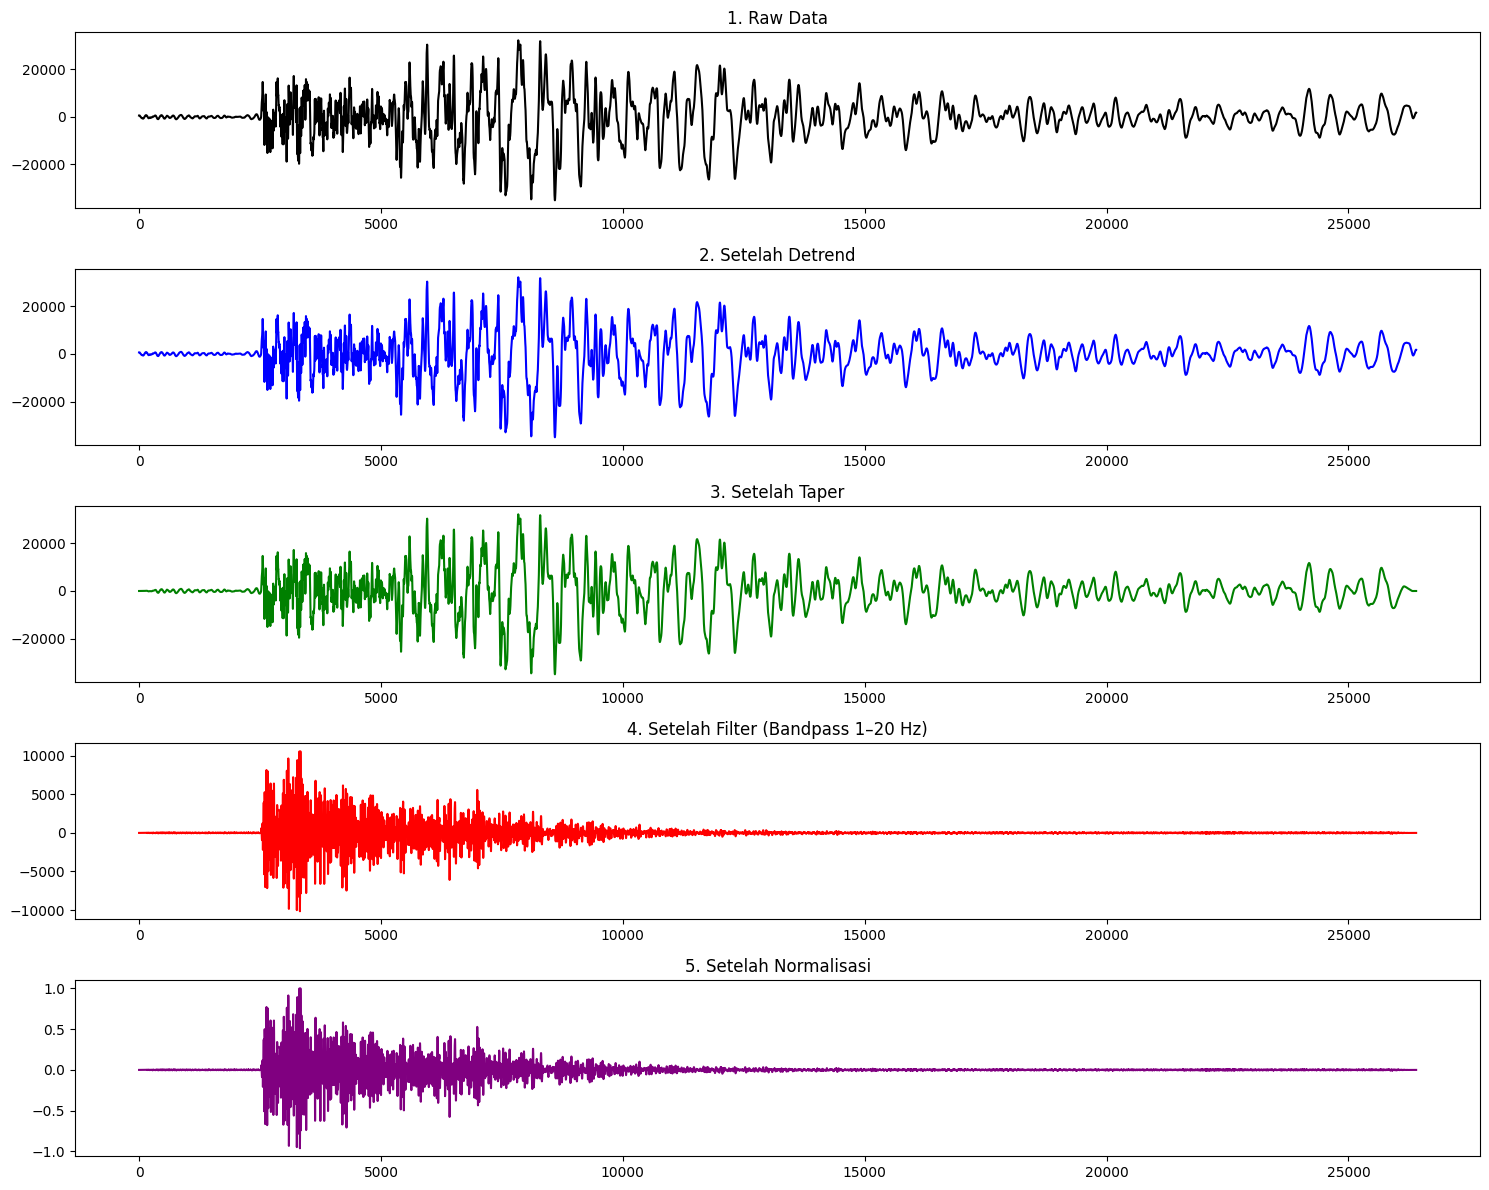

In [85]:
import matplotlib.pyplot as plt
from obspy import read
import numpy as np

# --- 1. Load data ---
tr_raw = read("/content/IU.MAJO.00.BHZ.M.2025.325.122220.SAC")[0]

# Copy agar tidak overwrite
tr_detrend = tr_raw.copy()
tr_taper   = tr_raw.copy()
tr_filter  = tr_raw.copy()
tr_norm    = tr_raw.copy()

# --- 2. Apply processing step by step ---
tr_detrend.detrend("linear")
tr_taper.detrend("linear")
tr_taper.taper(max_percentage=0.02, type="cosine")

tr_filter.detrend("linear")
tr_filter.taper(max_percentage=0.02, type="cosine")
tr_filter.filter("bandpass", freqmin=1, freqmax=20)

tr_norm.detrend("linear")
tr_norm.taper(max_percentage=0.02, type="cosine")
tr_norm.filter("bandpass", freqmin=1, freqmax=20)
data_norm = tr_norm.data / np.max(np.abs(tr_norm.data))


# --- 3. Plot all steps ---
plt.figure(figsize=(15, 12))

# Raw
plt.subplot(5,1,1)
plt.plot(tr_raw.data, color="black")
plt.title("1. Raw Data")

# Detrend
plt.subplot(5,1,2)
plt.plot(tr_detrend.data, color="blue")
plt.title("2. Setelah Detrend")

# Taper
plt.subplot(5,1,3)
plt.plot(tr_taper.data, color="green")
plt.title("3. Setelah Taper")

# Filter
plt.subplot(5,1,4)
plt.plot(tr_filter.data, color="red")
plt.title("4. Setelah Filter (Bandpass 1–20 Hz)")

# Normalisasi
plt.subplot(5,1,5)
plt.plot(data_norm, color="purple")
plt.title("5. Setelah Normalisasi")
plt.tight_layout()
plt.show()

In [86]:
data = tr.data
data = data / max(abs(data))
print(tr.data[:10])

[4428. 4449. 4402. 4336. 4296. 4298. 4283. 4242. 4353. 4468.]


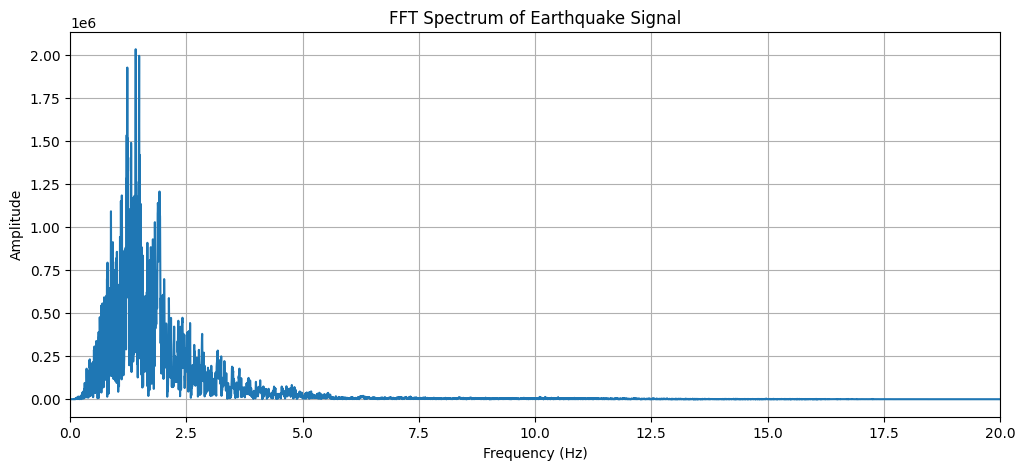

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

y_filtered = tr_filter.data
fs = tr_filter.stats.sampling_rate

# --- FFT ---
N = len(y_filtered)
fft_vals = np.fft.rfft(y_filtered)
fft_freq = np.fft.rfftfreq(N, d=1/fs)

fft_amp = np.abs(fft_vals)

plt.figure(figsize=(12,5))
plt.plot(fft_freq, fft_amp)
plt.title("FFT Spectrum of Earthquake Signal")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.xlim(0, fs/2)  # frekuensi hingga Nyquist
plt.grid(True)
plt.show()

In [88]:
peak_idx = np.argmax(fft_amp)
peak_freq = fft_freq[peak_idx]
peak_amp  = fft_amp[peak_idx]

print("Peak Frequency:", peak_freq, "Hz")
print("Peak Amplitude:", peak_amp)

Peak Frequency: 1.412121212121212 Hz
Peak Amplitude: 2031783.8699252384


In [89]:
# Energi sinyal (total)
energy_total = np.sum(y_filtered**2)

# Power sinyal
power_signal = np.mean(y_filtered**2)

print("Energy:", energy_total)
print("Power :", power_signal)

Energy: 33431830627.250492
Power : 1266357.2207291853


In [90]:
import numpy as np

# Misal y_filtered sudah ada
# Normalisasi ke rentang [-1, 1]
y_norm = y_filtered / np.max(np.abs(y_filtered))

# Energi sinyal (total)
energy_total = np.sum(y_norm**2)

# Power sinyal
power_signal = np.mean(y_norm**2)

print("Energy (normalisasi):", energy_total)
print("Power (normalisasi):", power_signal)

Energy (normalisasi): 298.8232438444442
Power (normalisasi): 0.011319062266835008


In [91]:
if power_signal < 0.01:
    level = "Lemah"
elif power_signal < 0.05:
    level = "Sedang"
else:
    level = "Kuat"

print("Tingkat Getaran:", level)


Tingkat Getaran: Sedang


Perbandingan hasil antara FFT dan PSD
Pada analisis FFT ini, kita melihat komponen frekuensi yang ada dalam sinyal dan melihat seberapa besar energi amplitudo sinyal pada tiap frekuensi. Hasil analisis ini menunjukkan adanya frekuensi dominan sebesar 1.412 Hz, menunjukkan energi terbesar dari getaran tersebut, adapun amplitudo tertinggi mencapai 126.635 sehingga frekuensi ini menanadakan besarnya kontribusi frekuensi terhadap bentuk keseluruhan sinya.

Kami juga melakukan perhitungan mengenai energi dan power untuk melakukan klasifikasi untuk gempa tersebut masuk ke dalam gempa yang rendah, sedang, atau kuat. Energi sinyal setelah dinormalisasi sebesar 298.82 dan power sebesar 0.0113 yang menunjukkan adanya energi yang dihasilkan getaran saat terjadi, yang dimana semakin besar nilainya akan semakin kuat juga getaran pada gempa yang terjadi dan power ini menggambarkan tingkat kestabilan kekuatan sinyal sepanjang rekaman.

DATA INDONESIA

In [92]:
import os
import numpy as np
import matplotlib.pyplot as plt
from obspy import read, UTCDateTime
from scipy.signal import welch

def basic_stats(tr):
    data = tr.data.astype(float)
    return {
        "npts": tr.stats.npts,
        "fs": tr.stats.sampling_rate, #sampling rate
        "duration_s": tr.stats.npts / tr.stats.sampling_rate, #menunjukkan durasi
        "min": np.min(data), #nilai min amplitudo
        "max": np.max(data), #nilai max amplitudo
        "mean": np.mean(data),
        "std": np.std(data), #men
    }

def is_clipped(tr, threshold_ratio=0.99):
    d = tr.data.astype(float)
    absmax = np.max(np.abs(d))
    n_close = np.sum(np.isclose(np.abs(d), absmax, atol=1e-8) | (np.abs(d) > absmax * threshold_ratio))
    frac = n_close / len(d)
    return frac > 0.001, frac

def estimate_snr(tr, pre_pick_sec=10.0, event_sec=20.0):
    n = tr.stats.npts
    fs = tr.stats.sampling_rate
    if n < int(fs*(pre_pick_sec+event_sec+1)):
        mid = n//2
        noise = tr.data[:mid]
        signal = tr.data[mid:]
    else:
        noise = tr.data[:int(fs*pre_pick_sec)]
        signal = tr.data[int(fs*pre_pick_sec):int(fs*(pre_pick_sec+event_sec))]
    noise_rms = np.sqrt(np.mean(noise**2)) + 1e-12
    signal_rms = np.sqrt(np.mean(signal**2)) + 1e-12
    return 20*np.log10(signal_rms / noise_rms)

def plot_spectrum(tr, ax=None):
    f, Pxx = welch(tr.data, fs=tr.stats.sampling_rate, nperseg=2048)
    if ax is None:
        plt.semilogy(f, Pxx)
        plt.xlabel("Hz"); plt.ylabel("PSD")
    else:
        ax.semilogy(f, Pxx)
        ax.set_xlabel("Hz"); ax.set_ylabel("PSD")

sac_files = [
    "/content/II.KAPI.00.BH1.M.2025.325.122955.SAC",
    "/content/II.KAPI.00.BH2.M.2025.325.122955.SAC",
    "/content/II.KAPI.00.BHZ.M.2025.325.122955.SAC",
    "/content/II.KAPI.10.BH1.M.2025.325.122955.SAC",
    "/content/II.KAPI.10.BH2.M.2025.325.122955.SAC",
    "/content/II.KAPI.10.BHZ.M.2025.325.122955.SAC",
]

results = []
for fpath in sac_files:
    if not os.path.exists(fpath):
        print("File not found:", fpath)
        continue
    st = read(fpath)
    tr = st[0]
    stats = basic_stats(tr)
    clipped, frac_clipped = is_clipped(tr)
    snr_db = estimate_snr(tr)
    results.append({
        "file": fpath,
        "channel": tr.stats.channel,
        "location": tr.stats.location,
        **stats,
        "clipped": clipped,
        "frac_clipped": frac_clipped,
        "snr_db": snr_db
    })


                                            file location channel    fs  \
0  /content/II.KAPI.00.BH1.M.2025.325.122955.SAC       00     BH1  40.0   
1  /content/II.KAPI.00.BH2.M.2025.325.122955.SAC       00     BH2  40.0   
2  /content/II.KAPI.00.BHZ.M.2025.325.122955.SAC       00     BHZ  40.0   
3  /content/II.KAPI.10.BH1.M.2025.325.122955.SAC       10     BH1  40.0   
4  /content/II.KAPI.10.BH2.M.2025.325.122955.SAC       10     BH2  40.0   
5  /content/II.KAPI.10.BHZ.M.2025.325.122955.SAC       10     BHZ  40.0   

   duration_s     min     max         std  clipped  frac_clipped    snr_db  
0       660.0 -3765.0  1388.0  361.912915    False      0.000038 -0.106664  
1       660.0 -1538.0  3879.0  376.399565    False      0.000114  0.085148  
2       660.0 -2253.0  1065.0  304.129101    False      0.000038  0.093941  
3       660.0  -904.0  2767.0  344.002455    False      0.000038 -0.174946  
4       660.0 -2508.0  5222.0  483.148059    False      0.000114 -0.171745  
5       660.

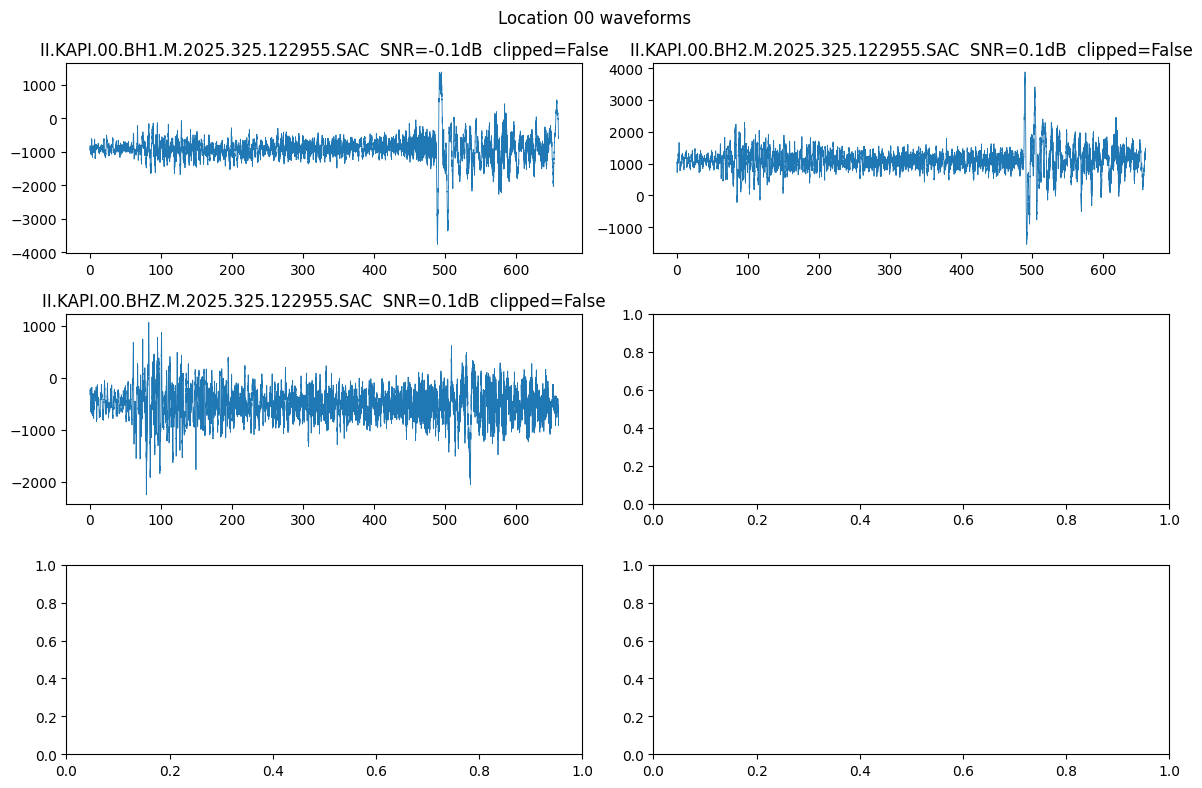

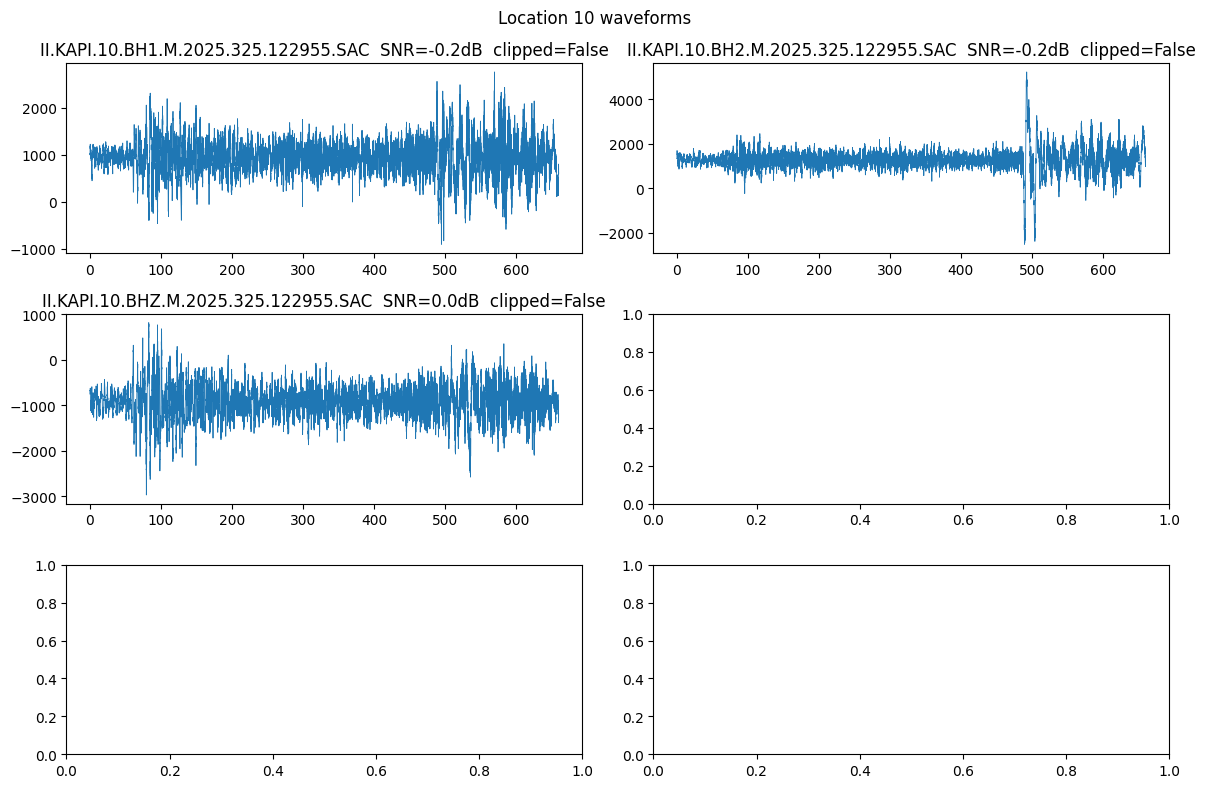

In [93]:
import pandas as pd
df = pd.DataFrame(results)
print(df[["file","location","channel","fs","duration_s","min","max","std","clipped","frac_clipped","snr_db"]])

locations = sorted(df['location'].unique())
for loc in locations:
    sel = df[df['location']==loc]
    if sel.empty: continue
    fig, axes = plt.subplots(3,2, figsize=(12,8))
    axes = axes.flatten()
    for idx, (i, row) in enumerate(sel.iterrows()):
        tr = read(row['file'])[0]
        ax = axes[idx]
        t = np.arange(tr.stats.npts)/tr.stats.sampling_rate
        ax.plot(t, tr.data, linewidth=0.6)
        ax.set_title(f"{os.path.basename(row['file'])}  SNR={row['snr_db']:.1f}dB  clipped={row['clipped']}")
    plt.suptitle(f"Location {loc} waveforms")
    plt.tight_layout()
    plt.show()

                                            file location channel    fs  \
0  /content/II.KAPI.00.BH1.M.2025.325.122955.SAC       00     BH1  40.0   
1  /content/II.KAPI.00.BH2.M.2025.325.122955.SAC       00     BH2  40.0   
2  /content/II.KAPI.00.BHZ.M.2025.325.122955.SAC       00     BHZ  40.0   
3  /content/II.KAPI.10.BH1.M.2025.325.122955.SAC       10     BH1  40.0   
4  /content/II.KAPI.10.BH2.M.2025.325.122955.SAC       10     BH2  40.0   
5  /content/II.KAPI.10.BHZ.M.2025.325.122955.SAC       10     BHZ  40.0   

   duration_s     min     max         std  clipped  frac_clipped    snr_db  
0       660.0 -3765.0  1388.0  361.912915    False      0.000038 -0.106664  
1       660.0 -1538.0  3879.0  376.399565    False      0.000114  0.085148  
2       660.0 -2253.0  1065.0  304.129101    False      0.000038  0.093941  
3       660.0  -904.0  2767.0  344.002455    False      0.000038 -0.174946  
4       660.0 -2508.0  5222.0  483.148059    False      0.000114 -0.171745  
5       660.

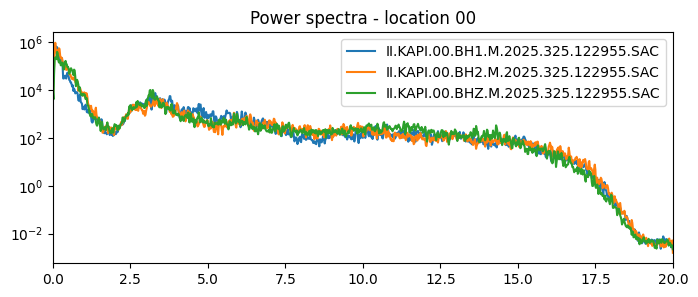

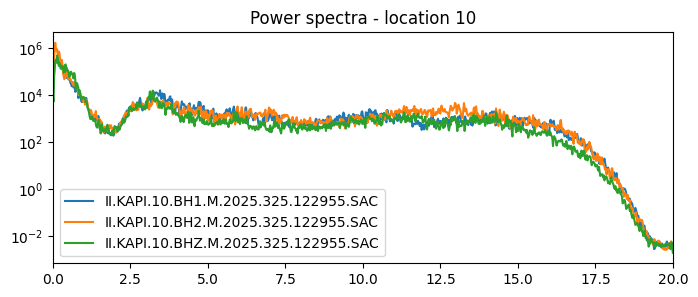

In [94]:
import pandas as pd
df = pd.DataFrame(results)
print(df[["file","location","channel","fs","duration_s","min","max","std","clipped","frac_clipped","snr_db"]])

locations = sorted(df['location'].unique())
for loc in locations:
    sel = df[df['location']==loc]
    if sel.empty: continue
    fig, ax = plt.subplots(1,1, figsize=(8,3))
    for i, row in sel.iterrows():
        tr = read(row['file'])[0]
        f, Pxx = welch(tr.data, fs=tr.stats.sampling_rate, nperseg=2048)
        ax.semilogy(f, Pxx, label=os.path.basename(row['file']))
    ax.set_xlim(0, tr.stats.sampling_rate/2)
    ax.legend()
    ax.set_title(f"Power spectra - location {loc}")
    plt.show()

In [95]:
loc_scores = {}
for loc in locations:
    sel = df[df['location']==loc]
    if sel.empty: continue
    score = sel['snr_db'].median() - (sel['frac_clipped'].median()*1000)
    loc_scores[loc] = score
print("Location scores:", loc_scores)
best_loc = max(loc_scores, key=loc_scores.get)
print("Recommended location:", best_loc)
print("Recommended files (3-component):")
print(df[df['location']==best_loc]['file'].tolist())

Location scores: {'00': 0.04726908468838894, '10': -0.20962346232298648}
Recommended location: 00
Recommended files (3-component):
['/content/II.KAPI.00.BH1.M.2025.325.122955.SAC', '/content/II.KAPI.00.BH2.M.2025.325.122955.SAC', '/content/II.KAPI.00.BHZ.M.2025.325.122955.SAC']


/usr/local/lib/python3.12/dist-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (20) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


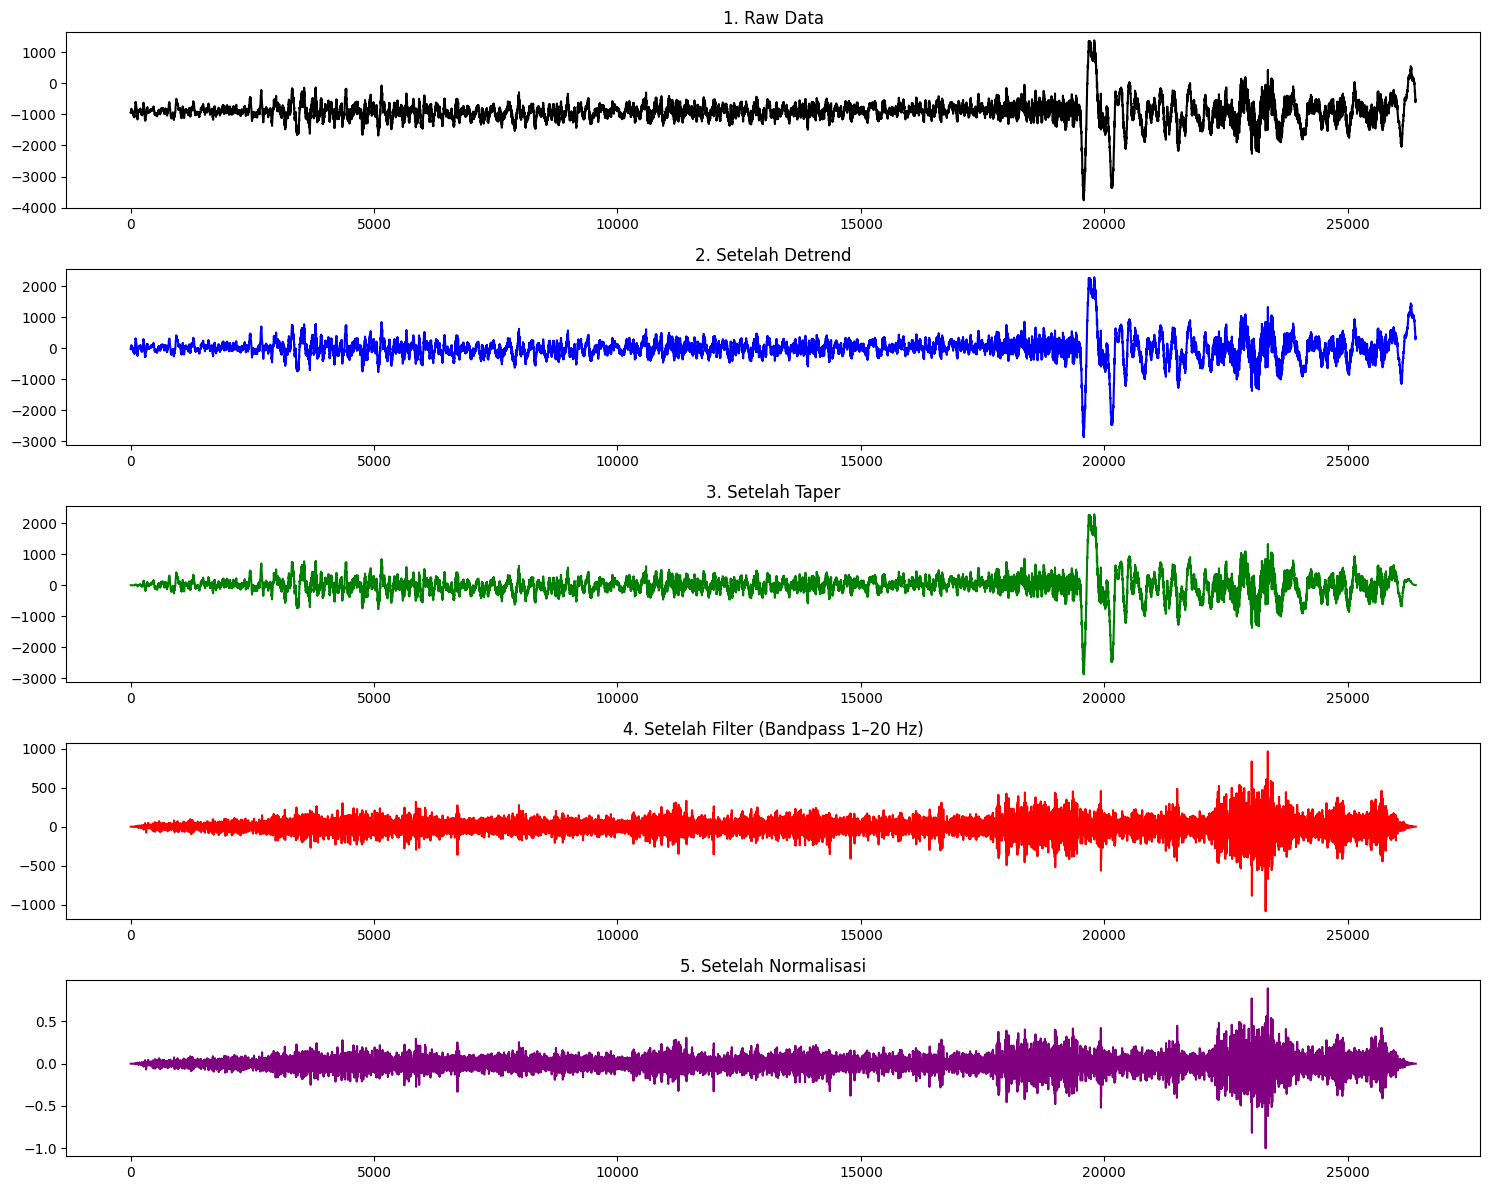

In [96]:
import matplotlib.pyplot as plt
from obspy import read
import numpy as np

# --- 1. Load data ---
tr_raw = read("/content/II.KAPI.00.BH1.M.2025.325.122955.SAC")[0]

# Copy agar tidak overwrite
tr_detrend = tr_raw.copy()
tr_taper   = tr_raw.copy()
tr_filter  = tr_raw.copy()
tr_norm    = tr_raw.copy()

# --- 2. Apply processing step by step ---
tr_detrend.detrend("linear")
tr_taper.detrend("linear")
tr_taper.taper(max_percentage=0.02, type="cosine")

tr_filter.detrend("linear")
tr_filter.taper(max_percentage=0.02, type="cosine")
tr_filter.filter("bandpass", freqmin=1, freqmax=20)

tr_norm.detrend("linear")
tr_norm.taper(max_percentage=0.02, type="cosine")
tr_norm.filter("bandpass", freqmin=1, freqmax=20)
data_norm = tr_norm.data / np.max(np.abs(tr_norm.data))


# --- 3. Plot all steps ---
plt.figure(figsize=(15, 12))

# Raw
plt.subplot(5,1,1)
plt.plot(tr_raw.data, color="black")
plt.title("1. Raw Data")

# Detrend
plt.subplot(5,1,2)
plt.plot(tr_detrend.data, color="blue")
plt.title("2. Setelah Detrend")

# Taper
plt.subplot(5,1,3)
plt.plot(tr_taper.data, color="green")
plt.title("3. Setelah Taper")

# Filter
plt.subplot(5,1,4)
plt.plot(tr_filter.data, color="red")
plt.title("4. Setelah Filter (Bandpass 1–20 Hz)")

# Normalisasi
plt.subplot(5,1,5)
plt.plot(data_norm, color="purple")
plt.title("5. Setelah Normalisasi")
plt.tight_layout()
plt.show()

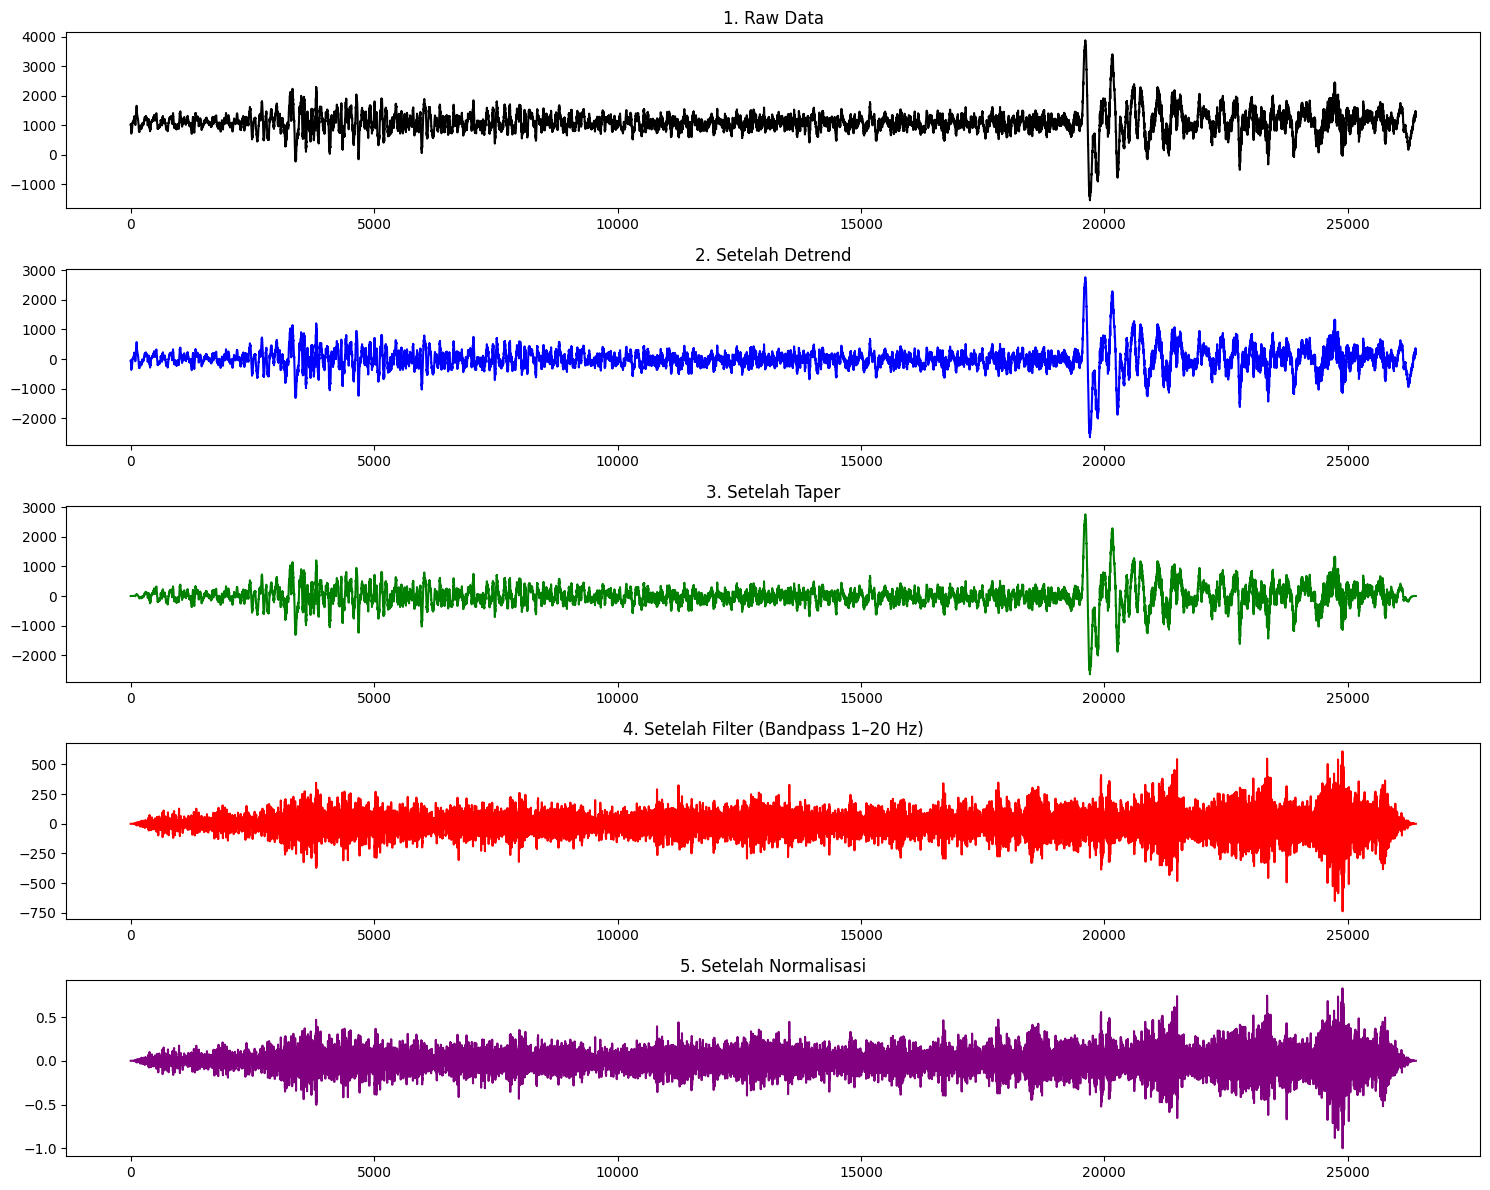

In [97]:
import matplotlib.pyplot as plt
from obspy import read
import numpy as np

# --- 1. Load data ---
tr_raw = read("/content/II.KAPI.00.BH2.M.2025.325.122955.SAC")[0]

# Copy agar tidak overwrite
tr_detrend = tr_raw.copy()
tr_taper   = tr_raw.copy()
tr_filter  = tr_raw.copy()
tr_norm    = tr_raw.copy()

# --- 2. Apply processing step by step ---
tr_detrend.detrend("linear")
tr_taper.detrend("linear")
tr_taper.taper(max_percentage=0.02, type="cosine")

tr_filter.detrend("linear")
tr_filter.taper(max_percentage=0.02, type="cosine")
tr_filter.filter("bandpass", freqmin=1, freqmax=20)

tr_norm.detrend("linear")
tr_norm.taper(max_percentage=0.02, type="cosine")
tr_norm.filter("bandpass", freqmin=1, freqmax=20)
data_norm = tr_norm.data / np.max(np.abs(tr_norm.data))


# --- 3. Plot all steps ---
plt.figure(figsize=(15, 12))

# Raw
plt.subplot(5,1,1)
plt.plot(tr_raw.data, color="black")
plt.title("1. Raw Data")

# Detrend
plt.subplot(5,1,2)
plt.plot(tr_detrend.data, color="blue")
plt.title("2. Setelah Detrend")

# Taper
plt.subplot(5,1,3)
plt.plot(tr_taper.data, color="green")
plt.title("3. Setelah Taper")

# Filter
plt.subplot(5,1,4)
plt.plot(tr_filter.data, color="red")
plt.title("4. Setelah Filter (Bandpass 1–20 Hz)")

# Normalisasi
plt.subplot(5,1,5)
plt.plot(data_norm, color="purple")
plt.title("5. Setelah Normalisasi")
plt.tight_layout()
plt.show()

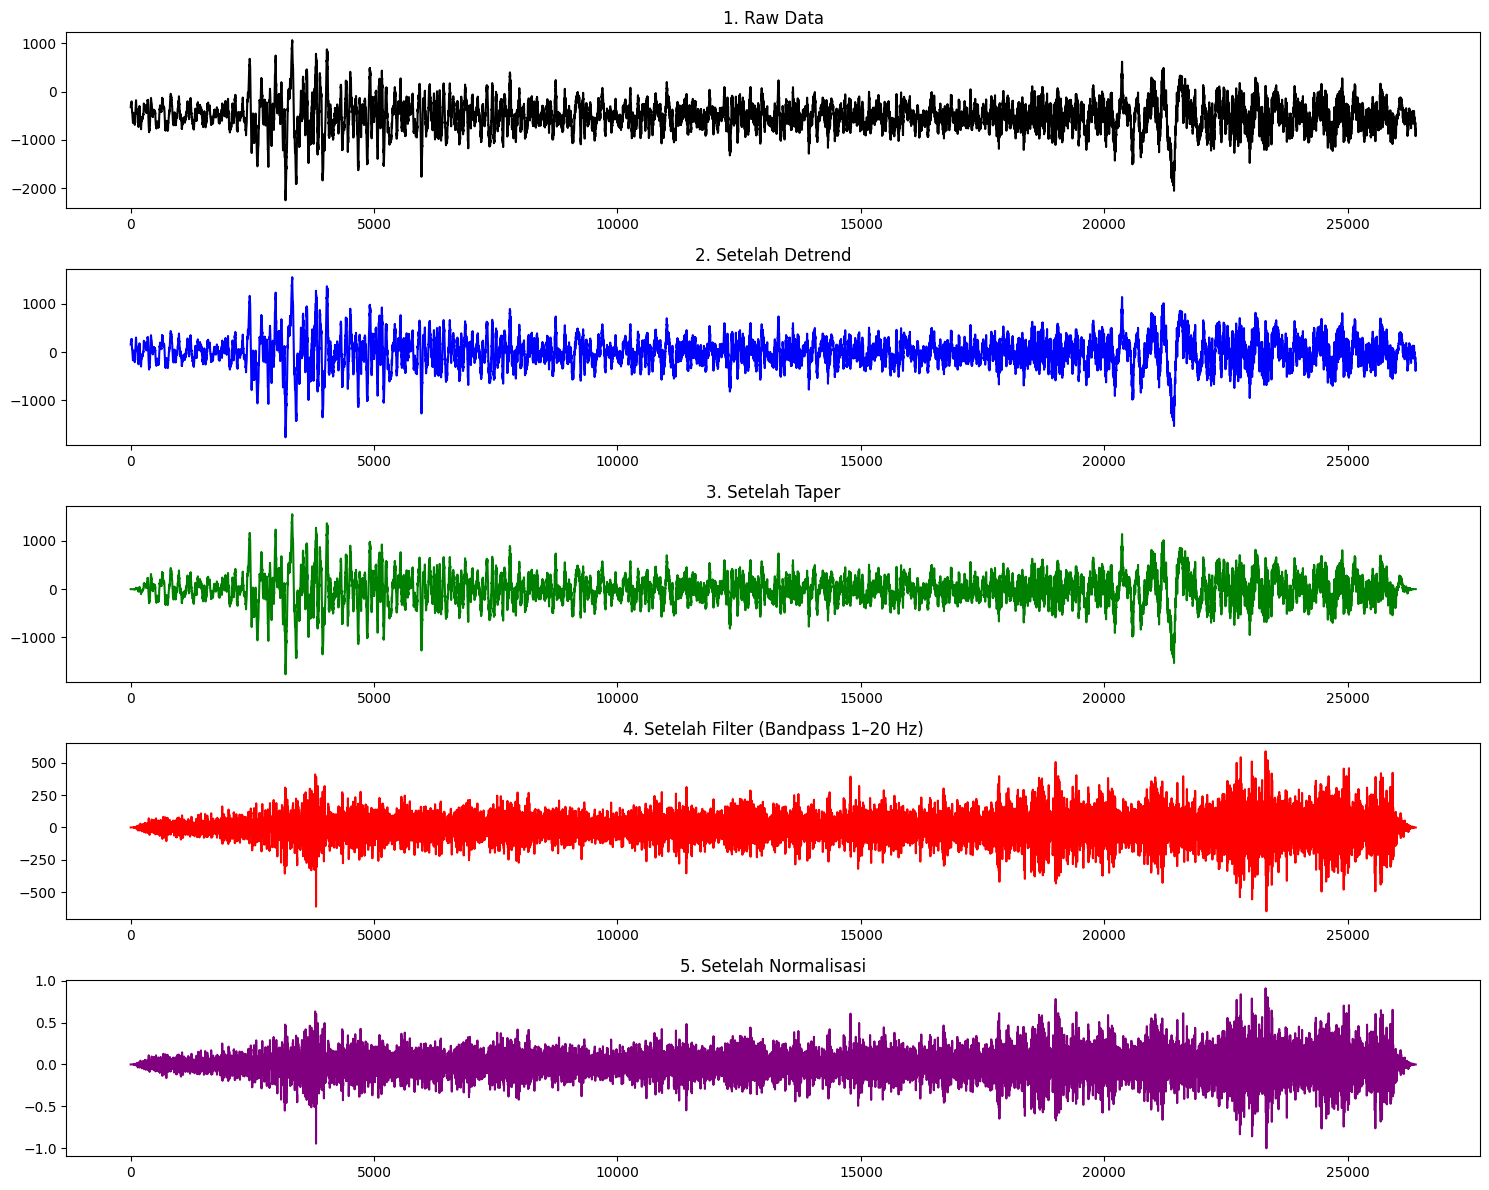

In [98]:
import matplotlib.pyplot as plt
from obspy import read
import numpy as np

# --- 1. Load data ---
tr_raw = read("/content/II.KAPI.00.BHZ.M.2025.325.122955.SAC")[0]

# Copy agar tidak overwrite
tr_detrend = tr_raw.copy()
tr_taper   = tr_raw.copy()
tr_filter  = tr_raw.copy()
tr_norm    = tr_raw.copy()

# --- 2. Apply processing step by step ---
tr_detrend.detrend("linear")
tr_taper.detrend("linear")
tr_taper.taper(max_percentage=0.02, type="cosine")

tr_filter.detrend("linear")
tr_filter.taper(max_percentage=0.02, type="cosine")
tr_filter.filter("bandpass", freqmin=1, freqmax=20)

tr_norm.detrend("linear")
tr_norm.taper(max_percentage=0.02, type="cosine")
tr_norm.filter("bandpass", freqmin=1, freqmax=20)
data_norm = tr_norm.data / np.max(np.abs(tr_norm.data))


# --- 3. Plot all steps ---
plt.figure(figsize=(15, 12))

# Raw
plt.subplot(5,1,1)
plt.plot(tr_raw.data, color="black")
plt.title("1. Raw Data")

# Detrend
plt.subplot(5,1,2)
plt.plot(tr_detrend.data, color="blue")
plt.title("2. Setelah Detrend")

# Taper
plt.subplot(5,1,3)
plt.plot(tr_taper.data, color="green")
plt.title("3. Setelah Taper")

# Filter
plt.subplot(5,1,4)
plt.plot(tr_filter.data, color="red")
plt.title("4. Setelah Filter (Bandpass 1–20 Hz)")

# Normalisasi
plt.subplot(5,1,5)
plt.plot(data_norm, color="purple")
plt.title("5. Setelah Normalisasi")
plt.tight_layout()
plt.show()

In [99]:
data = tr.data
data = data / max(abs(data))
print(tr.data[:10])

[-748. -722. -711. -698. -686. -687. -674. -669. -673. -668.]


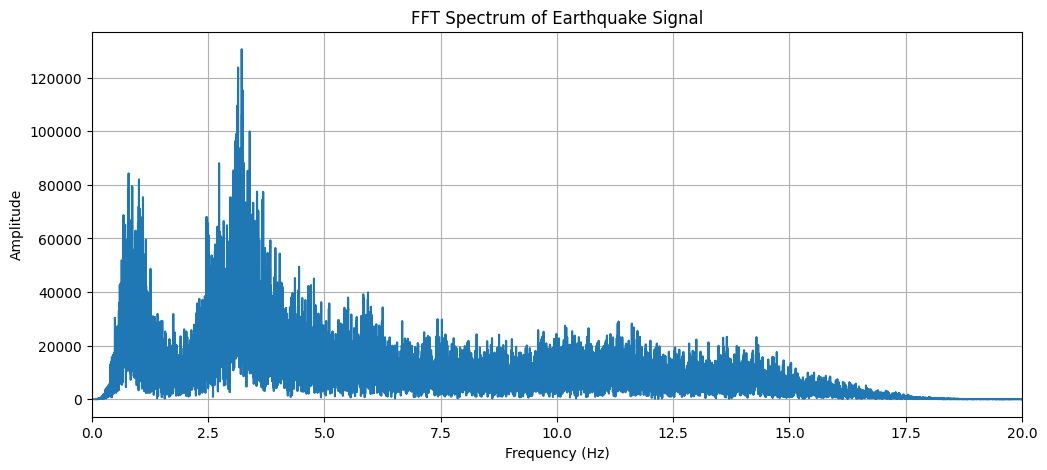

In [100]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

y_filtered = tr_filter.data
fs = tr_filter.stats.sampling_rate

# --- FFT ---
N = len(y_filtered)
fft_vals = np.fft.rfft(y_filtered)
fft_freq = np.fft.rfftfreq(N, d=1/fs)

fft_amp = np.abs(fft_vals)

plt.figure(figsize=(12,5))
plt.plot(fft_freq, fft_amp)
plt.title("FFT Spectrum of Earthquake Signal")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.xlim(0, fs/2)  # frekuensi hingga Nyquist
plt.grid(True)
plt.show()

In [101]:
peak_idx = np.argmax(fft_amp)
peak_freq = fft_freq[peak_idx]
peak_amp  = fft_amp[peak_idx]

print("Peak Frequency:", peak_freq, "Hz")
print("Peak Amplitude:", peak_amp)

Peak Frequency: 3.221212121212121 Hz
Peak Amplitude: 130574.29592639126


In [102]:
# Energi sinyal (total)
energy_total = np.sum(y_filtered**2)

# Power sinyal
power_signal = np.mean(y_filtered**2)

print("Energy:", energy_total)
print("Power :", power_signal)

Energy: 256445669.6121565
Power : 9713.851121672595


In [103]:
import numpy as np

# Misal y_filtered sudah ada
# Normalisasi ke rentang [-1, 1]
y_norm = y_filtered / np.max(np.abs(y_filtered))

# Energi sinyal (total)
energy_total = np.sum(y_norm**2)

# Power sinyal
power_signal = np.mean(y_norm**2)

print("Energy (normalisasi):", energy_total)
print("Power (normalisasi):", power_signal)

Energy (normalisasi): 612.7109069443936
Power (normalisasi): 0.023208746475166426


In [104]:
if power_signal < 0.01:
    level = "Lemah"
elif power_signal < 0.05:
    level = "Sedang"
else:
    level = "Kuat"

print("Tingkat Getaran:", level)


Tingkat Getaran: Sedang


Perbandingan hasil antara FFT dan PSD
Pada analisis FFT ini, kita melihat komponen frekuensi yang ada dalam sinyal dan melihat seberapa besar energi amplitudo sinyal pada tiap frekuensi. Hasil analisis ini menunjukkan adanya frekuensi dominan sebesar 3.22 Hz, menunjukkan energi terbesar dari getaran tersebut, adapun amplitudo tertinggi mencapai 130.574 sehingga frekuensi ini menanadakan besarnya kontribusi frekuensi terhadap bentuk keseluruhan sinya.

Kami juga melakukan perhitungan mengenai energi dan power untuk melakukan klasifikasi untuk gempa tersebut masuk ke dalam gempa yang rendah, sedang, atau kuat. Energi sinyal setelah dinormalisasi sebesar 612.71 dan power sebesar 0,0232 yang menunjukkan adanya energi yang dihasilkan getaran saat terjadi, yang dimana semakin besar nilainya akan semakin kuat juga getaran pada gempa yang terjadi dan power ini menggambarkan tingkat kestabilan kekuatan sinyal sepanjang rekaman.